# Mutual Fund Price Prediction

# Mary Donovan Martello

## The goal of this project was to design models to predict mutual fund return values and to identify the features that best predict those return values. This notebook includes data cleaning and preparation, exploratory data analysis and dimensionality reduction.

# Part 1:  EDA, Data Preparation and Dimensionality Reduction.

In [1]:
# import libraries
from __future__ import print_function, division

%matplotlib inline

# import libraries

import numpy as np
import pandas as pd
import random
import yellowbrick
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso


from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import make_pipeline

#stop unnecessary warnings from printing to the screen
import warnings
warnings.simplefilter('ignore')

C:\Users\trave\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### This data source contains 25,000+ mutual funds with 125 features including general aspects (as total net assets, management company and size), portfolio indicators (as cash, stocks, bonds, and sectors), returns (as year-to-date, 2018-10) and financial ratios (as price/earnings, Treynor and Sharpe ratios, alpha, and beta).  The target variable it year-to-date return (ytd_return) of the mutual funds.

In [2]:
# Load data into a dataframe
# import file
mf = pd.read_csv('Mutual Funds.csv')


### Examine the dataframe.

In [3]:
# Check the dimension of the dataframe 
mf.shape

(25308, 125)

In [4]:
# Look at the data
mf.head()

fund_name                                 fund_extended_name  \
0     AAAAX               DWS RREEF Real Assets Fund - Class A   
1     AAADX               Aberdeen Income Builder Fund Class A   
2     AAAGX             Thrivent Large Cap Growth Fund Class A   
3     AAAIX  American Century Strategic Allocation: Aggress...   
4     AAANX  Horizon Active Asset Allocation Fund Investor ...   

                         category                   fund_family    net_assets  \
0                World Allocation                           DWS  5.302800e+08   
1                     Large Blend                      Aberdeen  8.884000e+07   
2                    Large Growth                Thrivent Funds  1.080000e+09   
3  Allocation - 70% to 85% Equity  American Century Investments  7.852700e+08   
4             Tactical Allocation           Horizon Investments  5.271300e+08   

   ytd_return  fund_yield  morningstar_rating inception_date investment  ...  \
0       12.79        1.43                   3     2007-07-29      Blend  ...   
1        9.21        2.62                   2     2011-12-29      Blend  ...   
2       16.00        0.00                   3     1999-10-28     Growth  ...   
3       11.57        1.38                   4     2000-07-31     Growth  ...   
4       11.62        0.66                   4     2012-01-30      Blend  ...   

  fund_sharpe_ratio_5years category_sharpe_ratio_5years  \
0                     0.31                         0.00   
1                     0.62                         0.01   
2                     0.86                         0.01   
3                     0.63                         0.01   
4                     0.47                         0.00   

   fund_sharpe_ratio_10years  category_sharpe_ratio_10years  \
0                       0.73                           0.01   
1                       0.97                           0.01   
2                       1.01                           0.01   
3                       1.00                           0.01   
4                        NaN                           0.01   

   fund_treynor_ratio_3years  category_treynor_ratio_3years  \
0                       5.05                           0.05   
1                      11.55                           0.11   
2                      12.65                           0.13   
3                       5.77                           0.05   
4                        4.5                           0.04   

   fund_treynor_ratio_5years  category_treynor_ratio_5years  \
0                       2.26                           0.02   
1                       6.91                           0.08   
2                      10.22                           0.10   
3                       4.14                           0.03   
4                       2.98                           0.03   

   fund_treynor_ratio_10years  category_treynor_ratio_10years  
0                        6.71                            0.07  
1                       12.77                            0.14  
2                       13.44                            0.15  
3                        8.24                            0.08  
4                         NaN                            0.09  

[5 rows x 125 columns]

## Data Cleaning

> In looking at the data and the warnings upon loading the data, there are a few cleaning steps that must be accomplished before more analysis can be done.


> Address mixed data types

In [5]:
# Clean the data
# Importing the file with pandas showed that six columns had mixed datatypes.  The warning says to set datatype to object, but
#   that did not work because then the numbers were strings instead of integers or floats.  
# In examining these columns I discovered that some of the values were entered as strings with a comma in them.  I transformed
#    these six columns by replacing the commas in the strings so that I could convert the datatypes to floats.

mf['price_earnings'] = mf['price_earnings'].str.replace(',', "").astype(float)
mf['price_sales'] = mf['price_sales'].str.replace(',', "").astype(float)
mf['price_cashflow'] = mf['price_cashflow'].str.replace(',', "").astype(float)
mf['fund_treynor_ratio_3years'] = mf['fund_treynor_ratio_3years'].str.replace(',', "").astype(float)
mf['fund_treynor_ratio_5years'] = mf['fund_treynor_ratio_5years'].str.replace(',', "").astype(float)
mf['fund_treynor_ratio_10years'] = mf['fund_treynor_ratio_10years'].str.replace(',', "").astype(float)
mf['median_market_cap'] = mf['median_market_cap'].str.replace(',', "").astype(float)

> Address missing values

In [6]:
# Clean the data cont.
# drop columns with too many missing values (greater than 6000 missing values)
mf.drop(columns = ['price_earnings', 'price_sales', 'price_cashflow', 'bond_maturity', 'bond_duration', 'fund_return_2014',
                  'category_return_2014', 'fund_return_2013', 'category_return_2013', 'fund_return_2012', 'category_return_2012',
                  'fund_return_2011', 'fund_return_2010', 'category_return_2010', 'fund_alpha_10years', 'fund_beta_10years',
                  'fund_mean_annual_return_10years', 'fund_r_squared_10years', 'fund_standard_deviation_10years', 'fund_sharpe_ratio_10years',
                  'fund_treynor_ratio_3years', 'fund_treynor_ratio_5years', 'fund_treynor_ratio_10years'], inplace = True)

In [7]:
mf.shape

(25308, 102)

In [8]:
# check the data types 

def types(df):
    """
    Prints DataFrame attribute types (numerical or 
    categorical) to the stdout.
    
    Arguments:
        df: Dataset pandas DataFrame.        
    """
    for c, t in zip(df, df.dtypes):
        if np.issubdtype(t, np.number):
            print("Num", c, t)
        else:
            print("Cat", c, t)
            
#types(mf)

> Replace missing values in string columns and float columns


In [9]:
# fill in string missing values
mf[['investment', 'size']] = mf[['investment', 'size']].fillna('FILL')

In [10]:
# drop rows with missing values because cannot impute values from other mutual fund data to predict target mutual fund 
df = mf.dropna(axis = 0, how ='any')


In [11]:
df.shape

(14292, 102)

In [12]:
# check change in dataframe from removing missing data rows
print("Old data frame length:", len(mf)) 
print("New data frame length:", len(df))  
print("Number of rows with at least 1 NA value: ", 
      (len(mf)-len(df)))

Old data frame length: 25308
New data frame length: 14292
Number of rows with at least 1 NA value:  11016


In [13]:
df.shape

(14292, 102)

> Address low-value features

In [14]:
# drop columns with too many unique values, only one value, duplicate or low-value information
df.drop(columns = ['fund_name', 'fund_extended_name', 'category', 'fund_family', 'inception_date', 'currency', 
                   'fund_return_ytd', 'rating_us_government', 'category_return_3months' ], inplace = True)

In [15]:
# check new dimensions
df.shape

(14292, 93)

> Address outliers

> I checked for outliers with histograms, point plots and value counts but did not find any. Some of the sample code for doing so is below.

In [237]:
# histograms did not show outlier


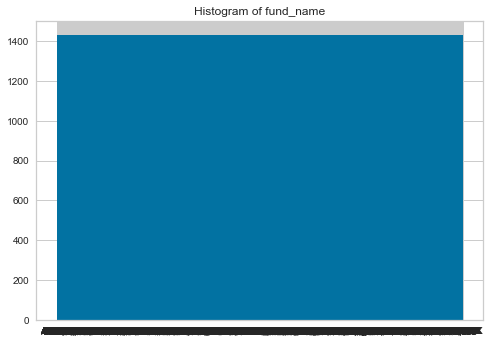

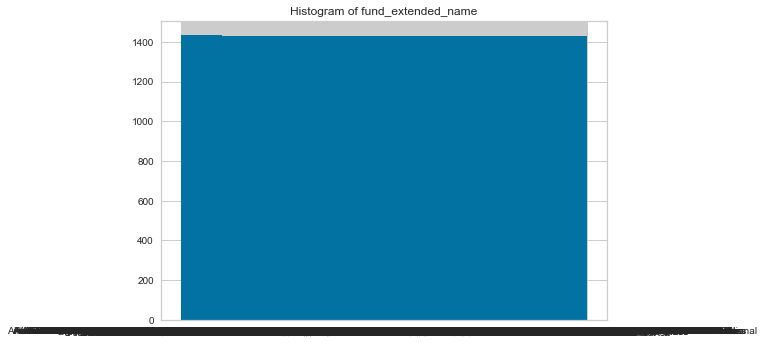

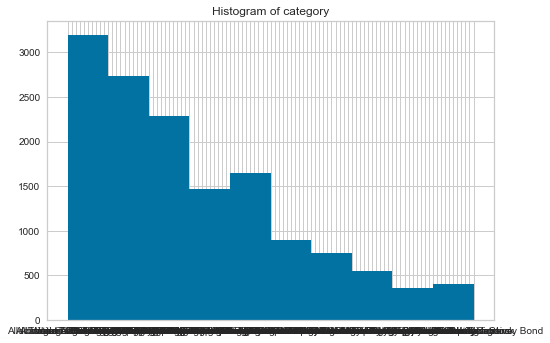

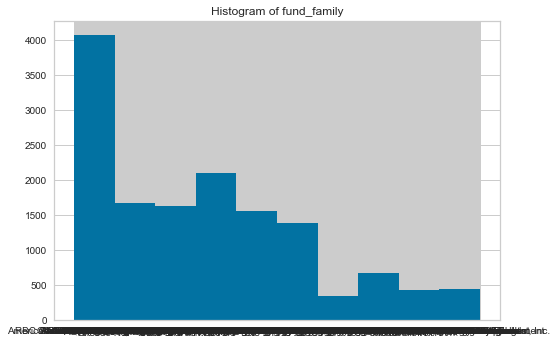

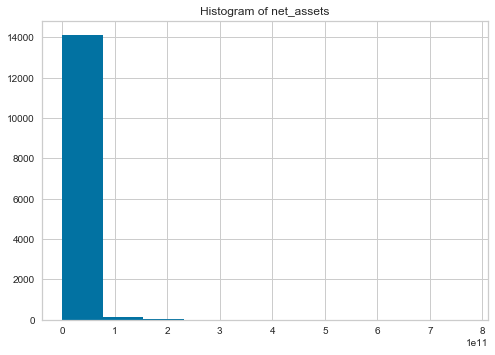

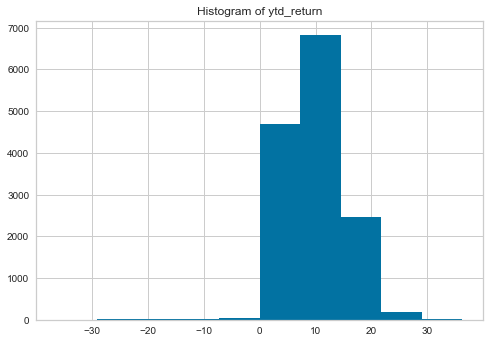

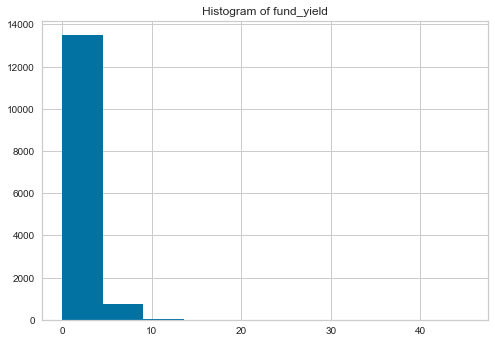

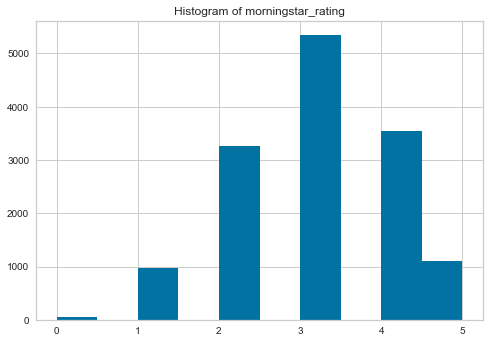

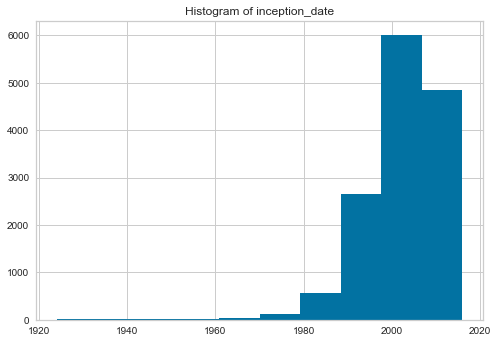

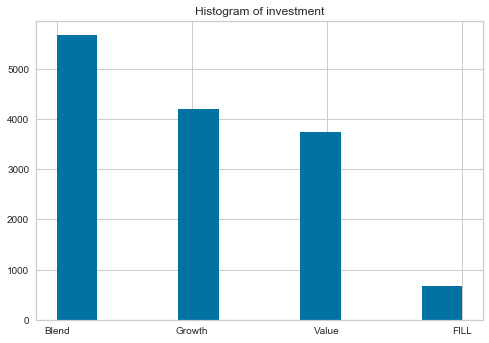

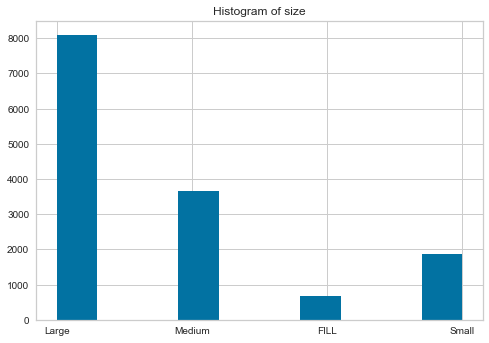

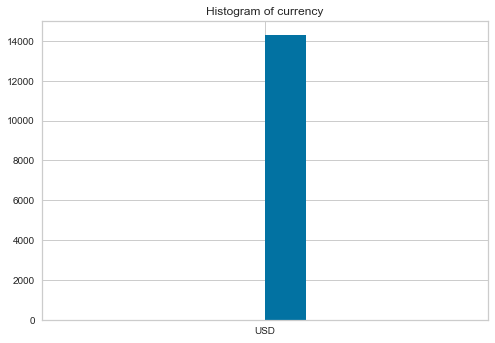

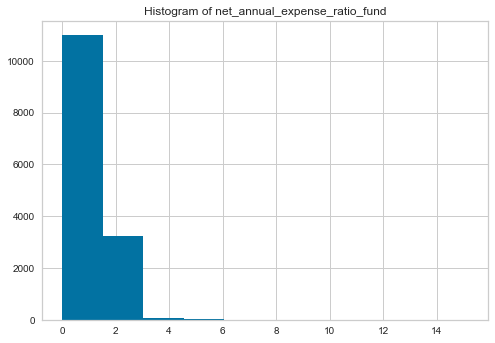

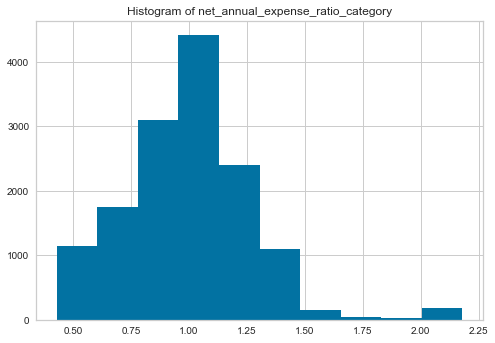

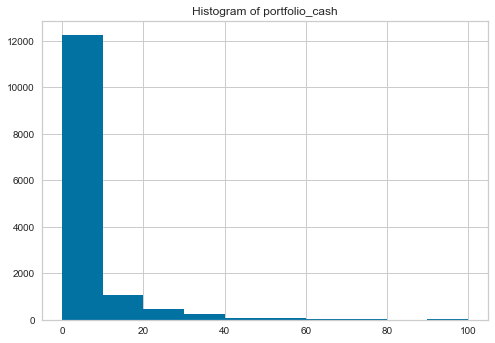

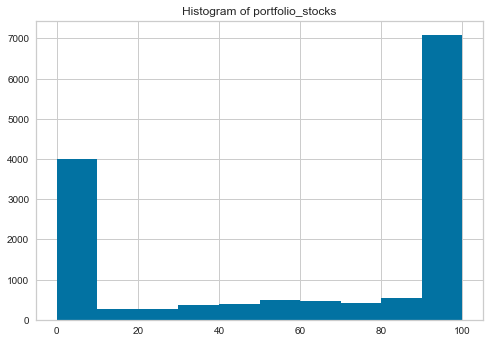

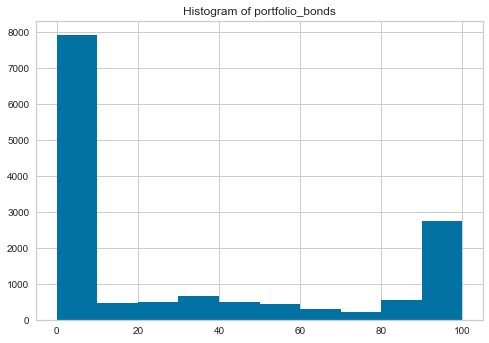

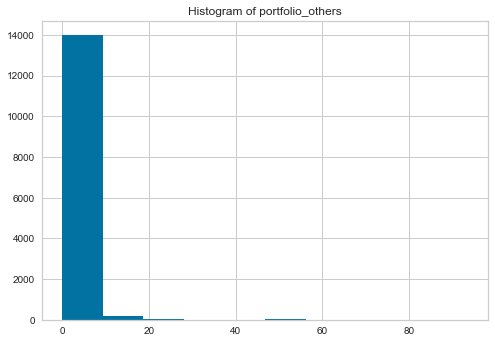

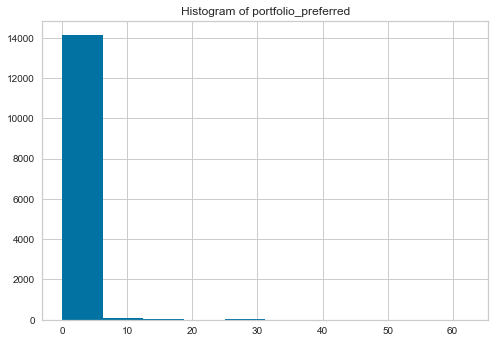

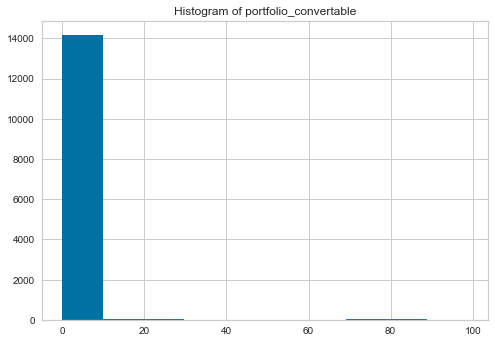

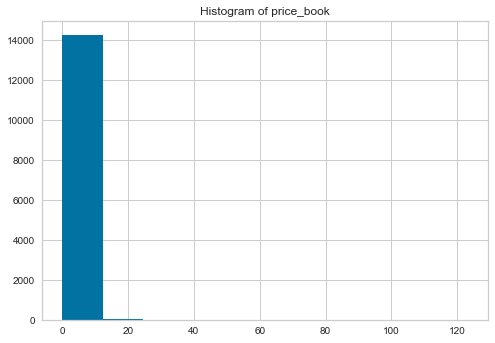

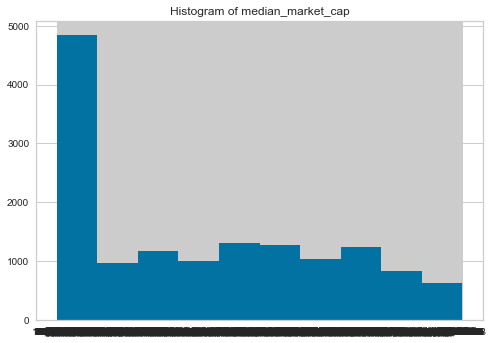

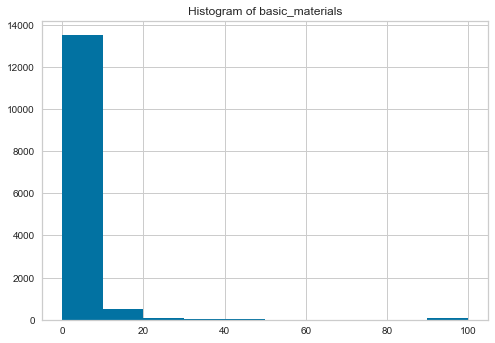

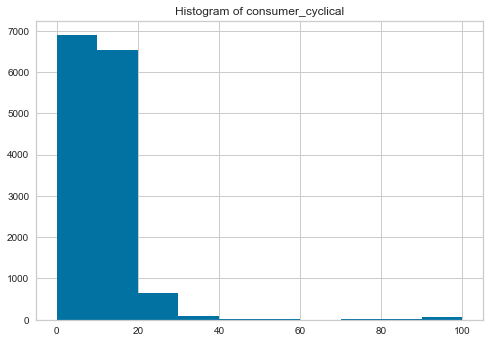

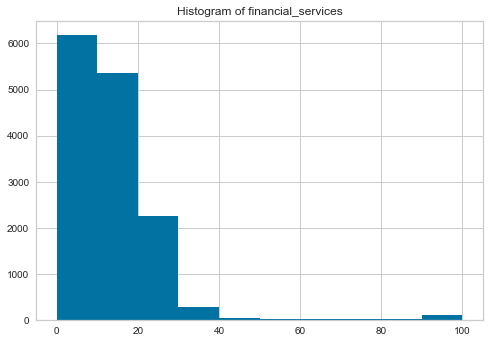

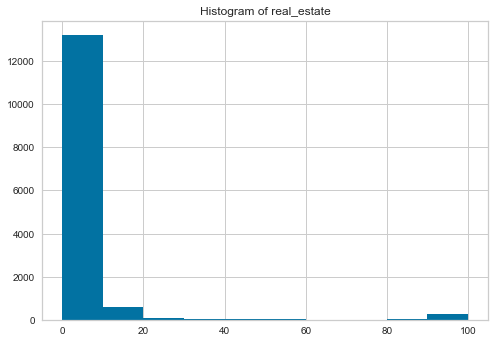

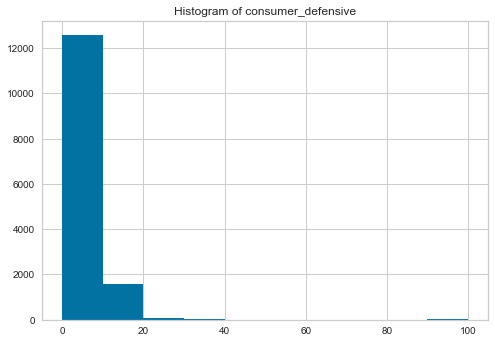

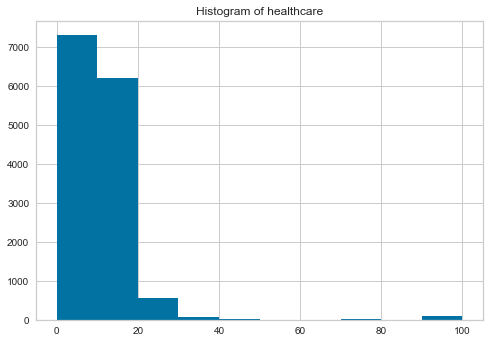

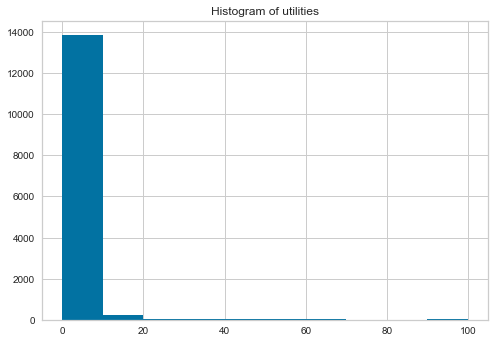

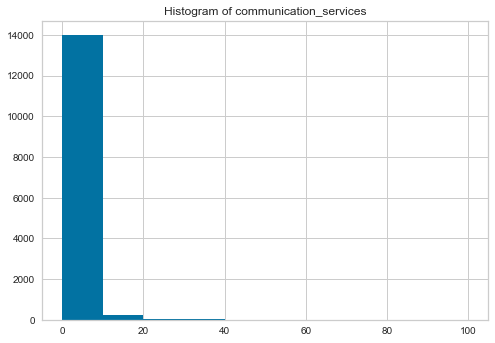

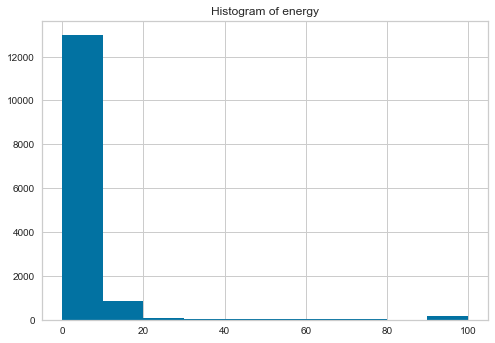

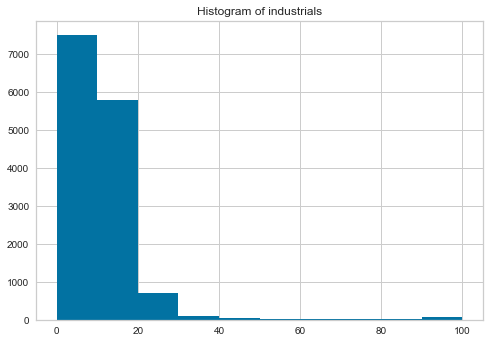

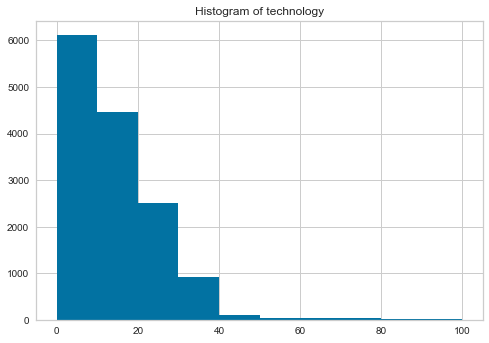

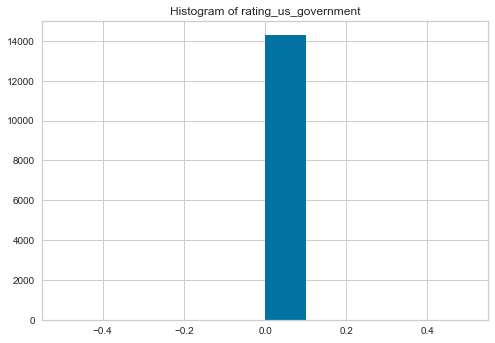

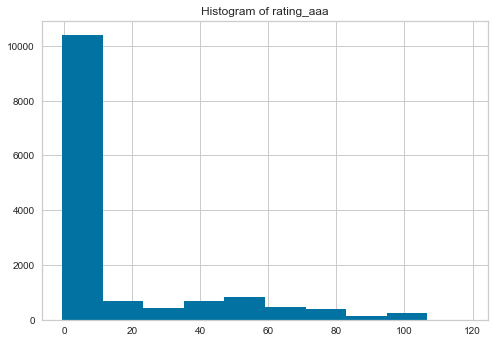

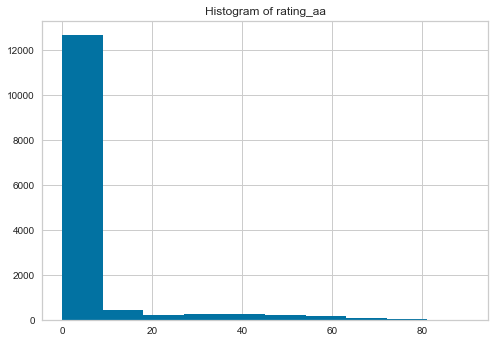

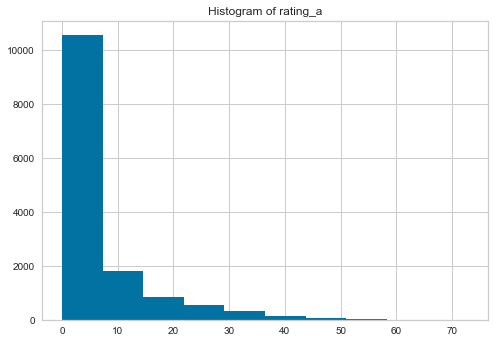

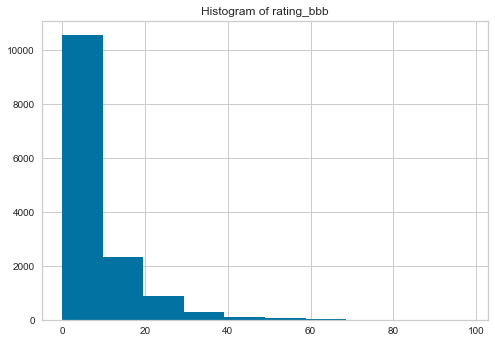

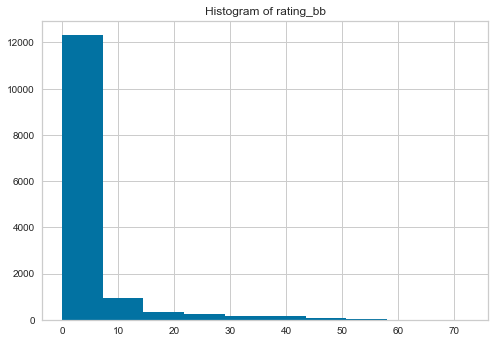

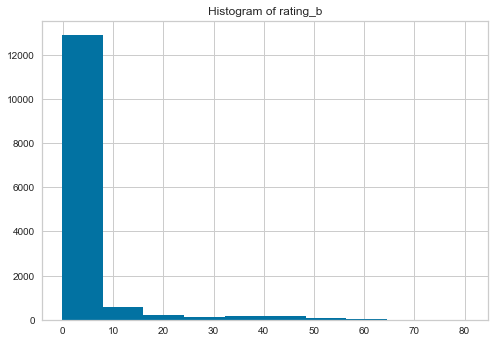

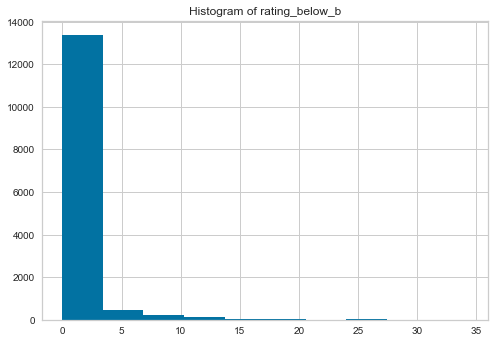

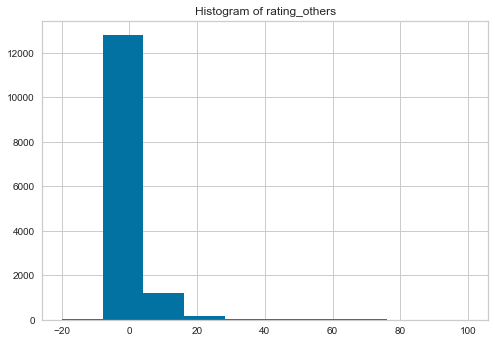

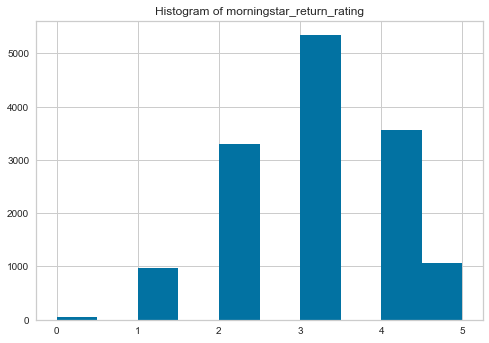

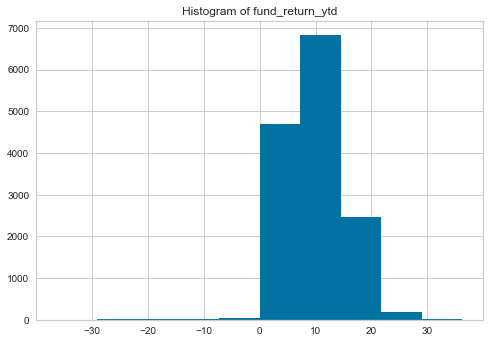

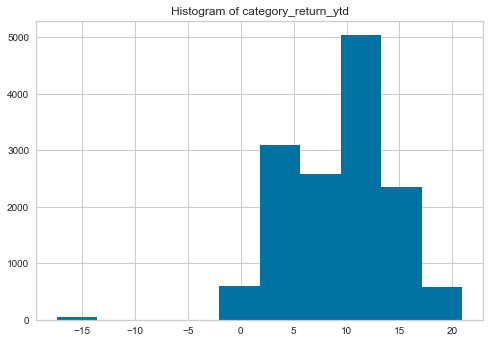

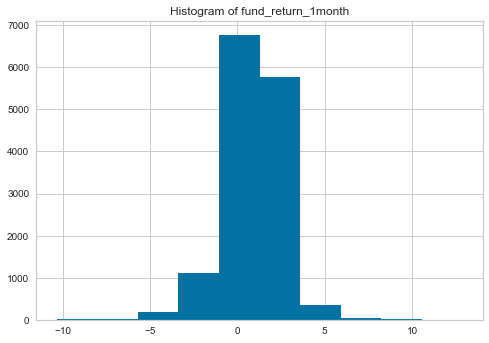

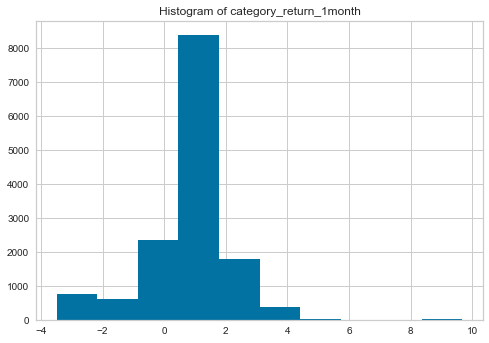

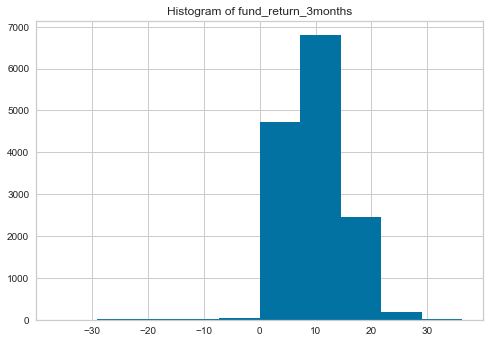

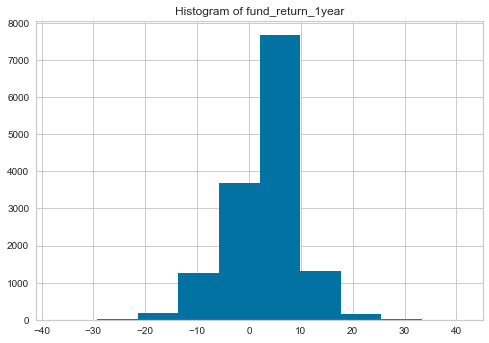

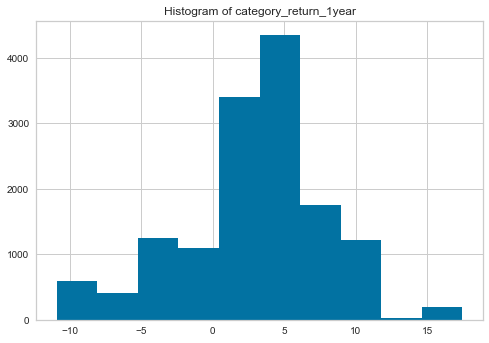

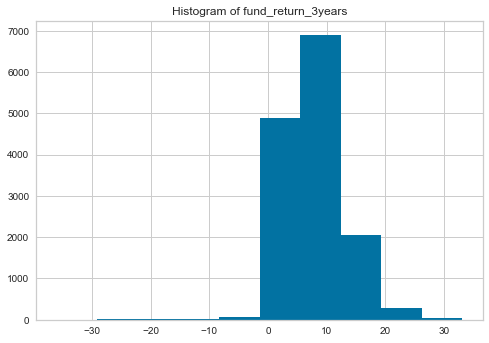

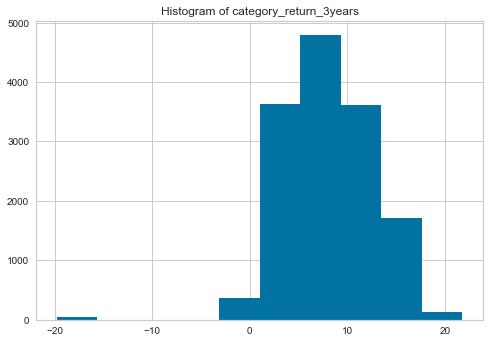

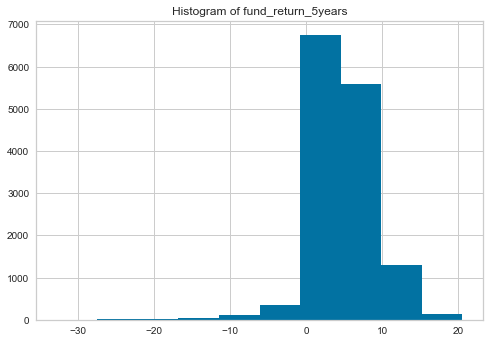

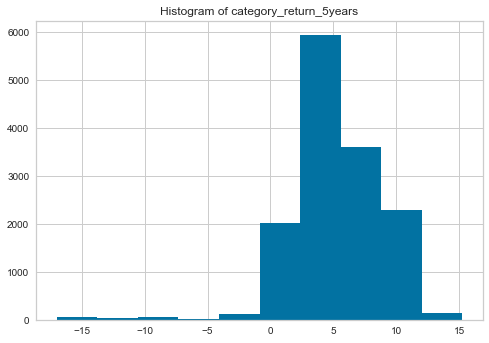

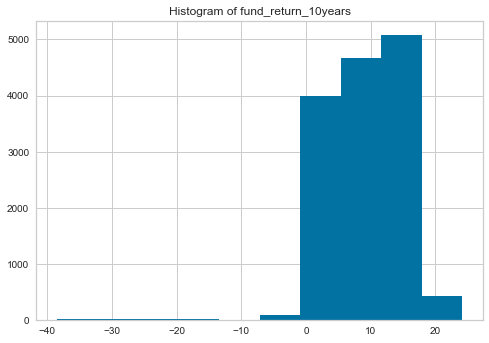

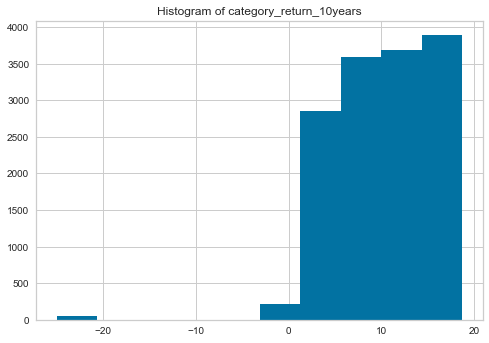

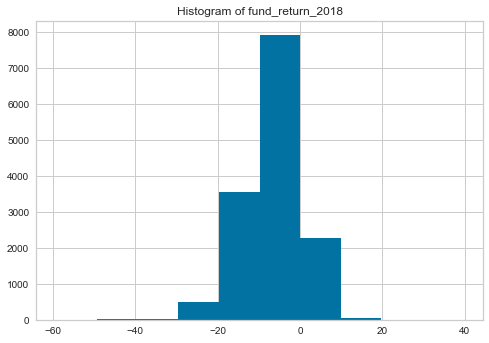

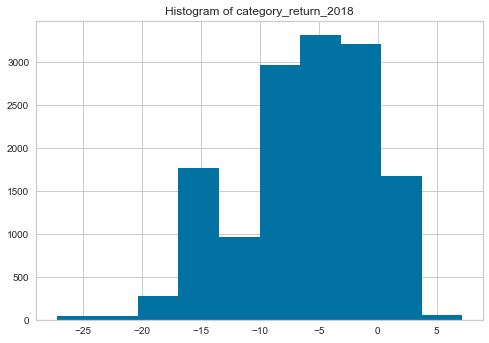

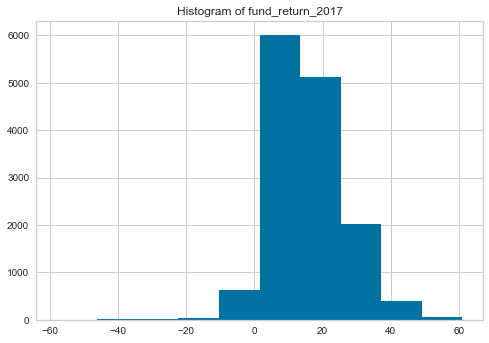

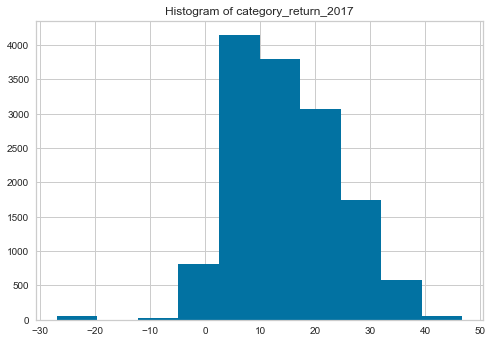

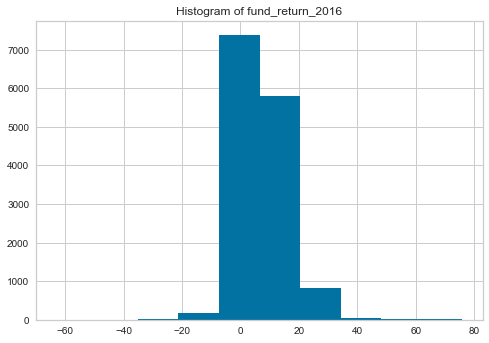

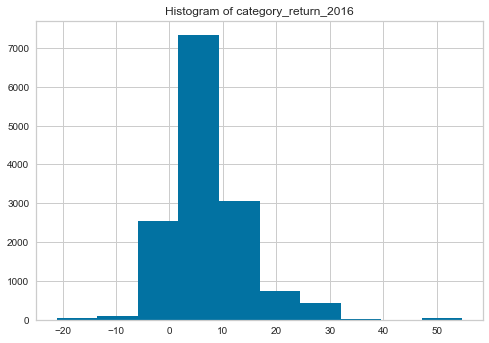

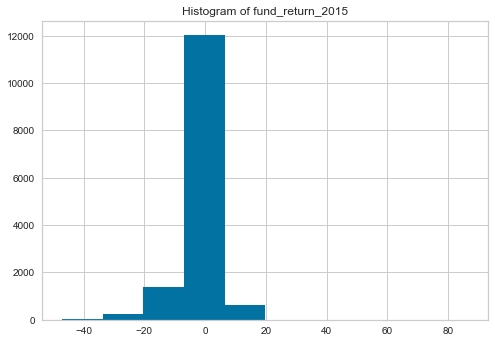

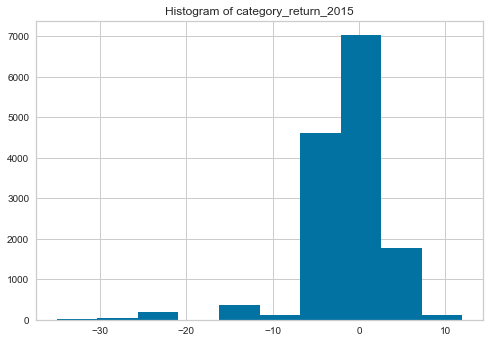

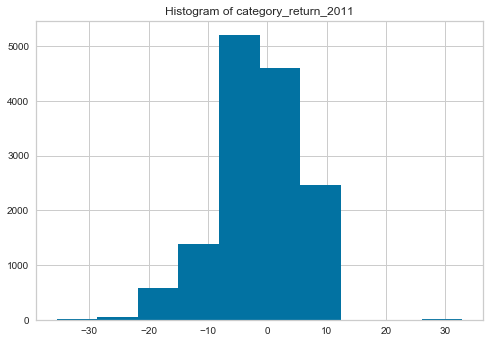

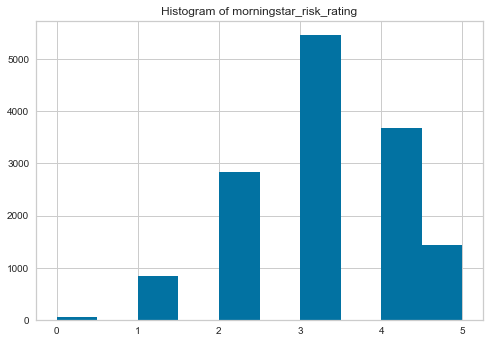

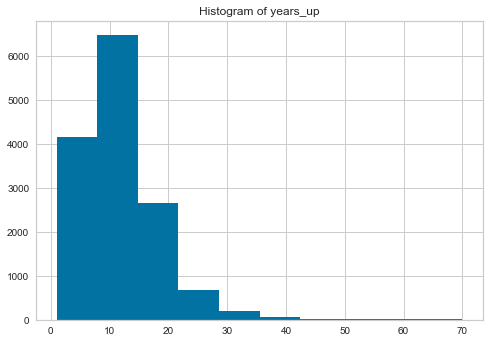

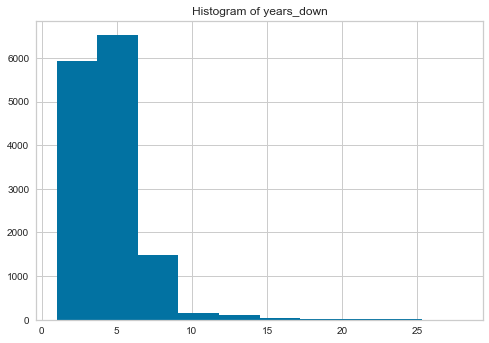

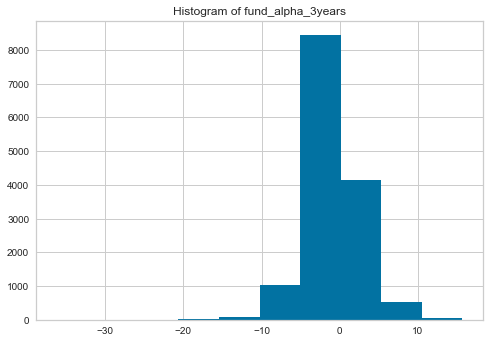

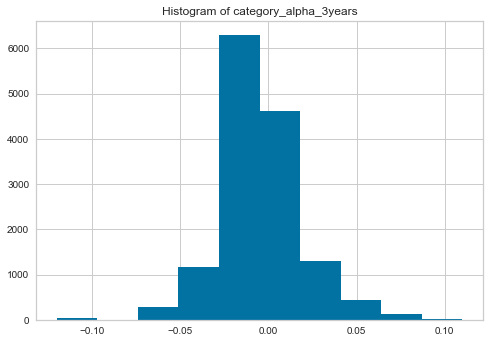

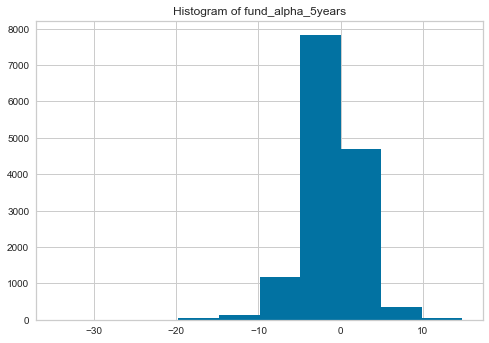

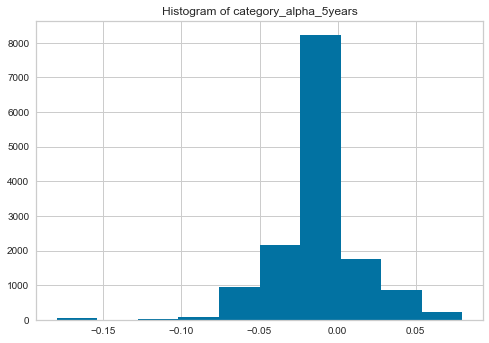

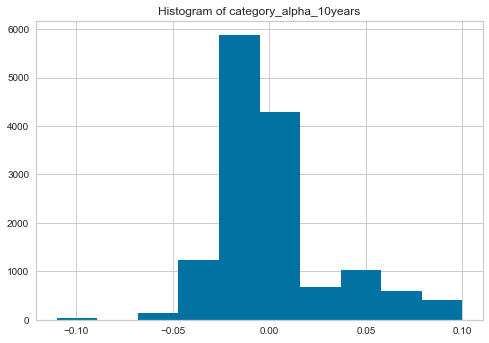

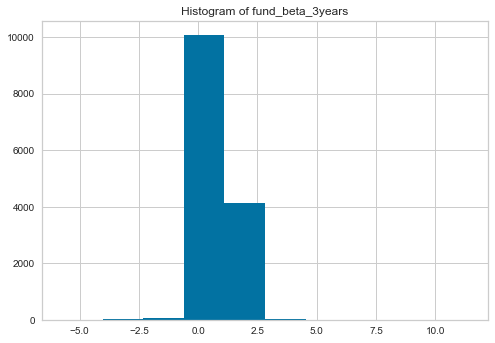

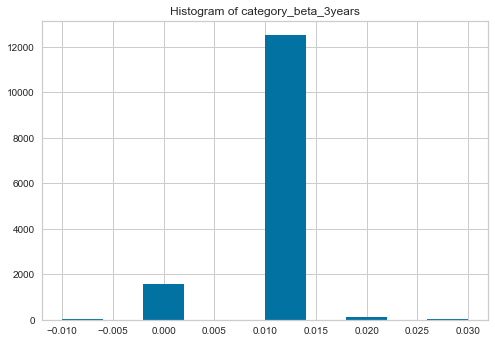

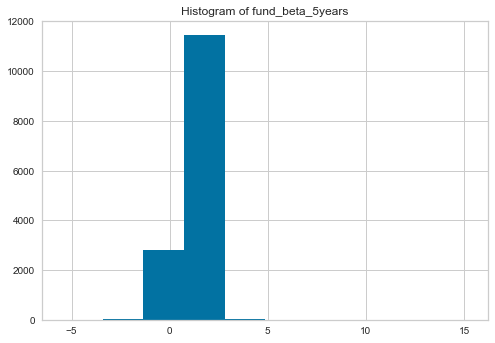

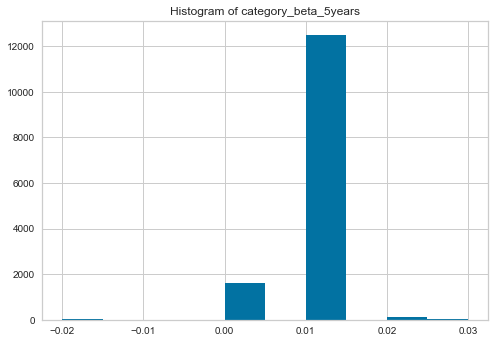

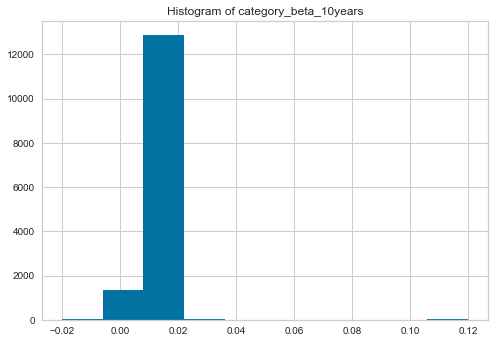

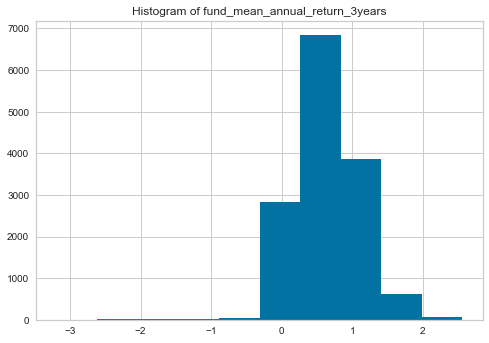

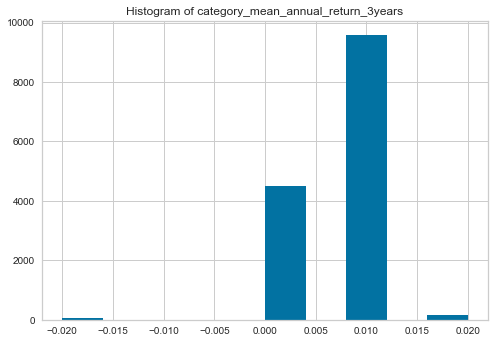

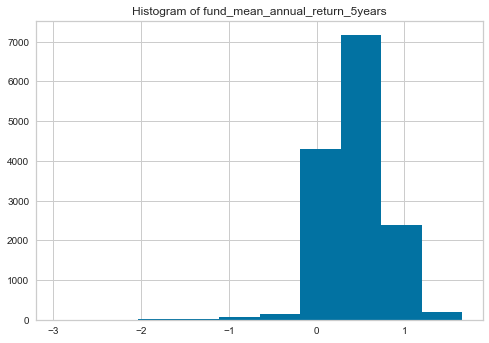

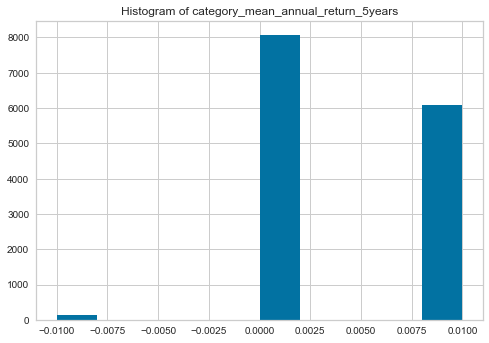

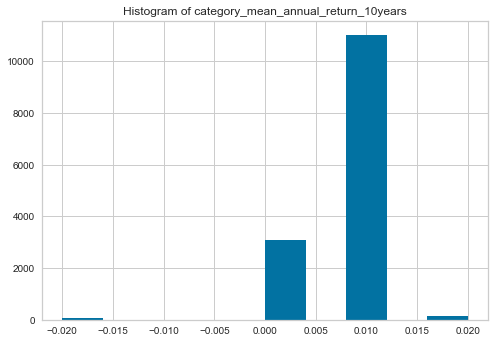

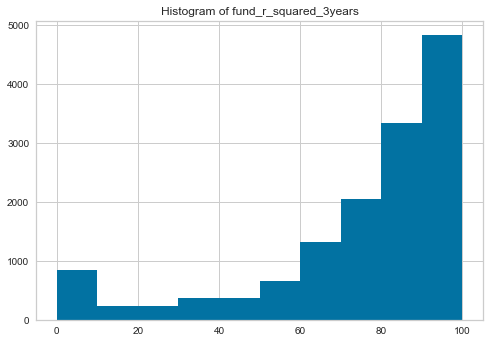

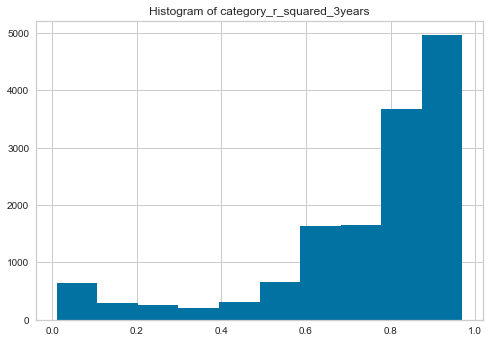

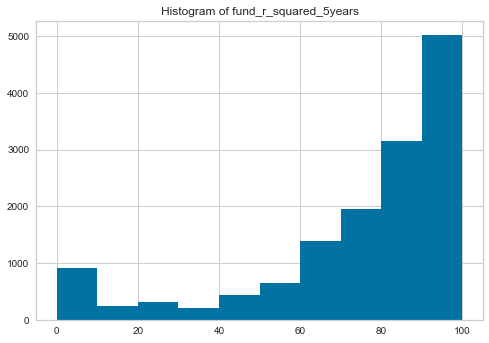

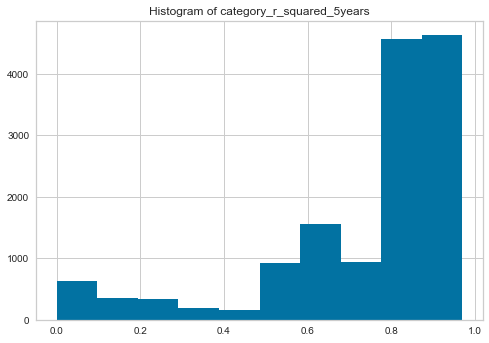

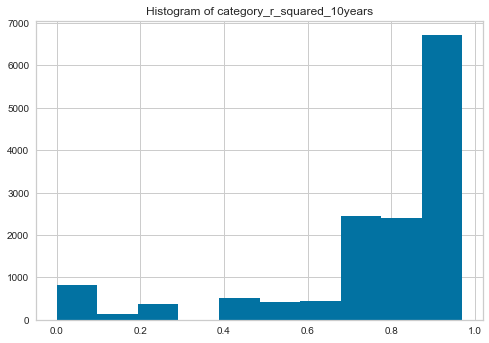

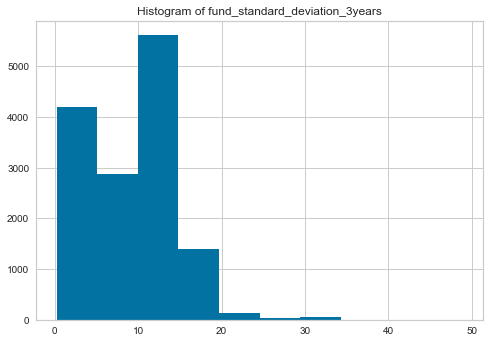

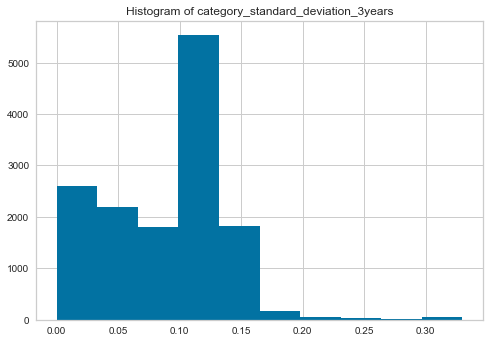

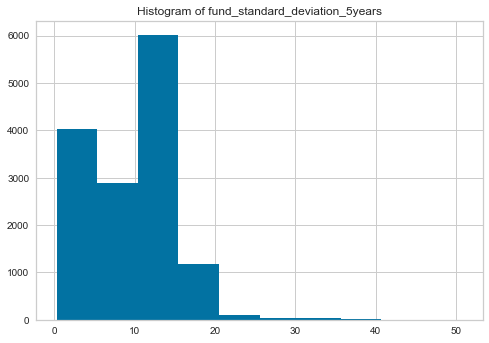

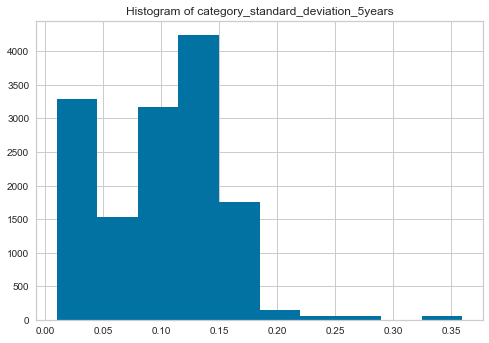

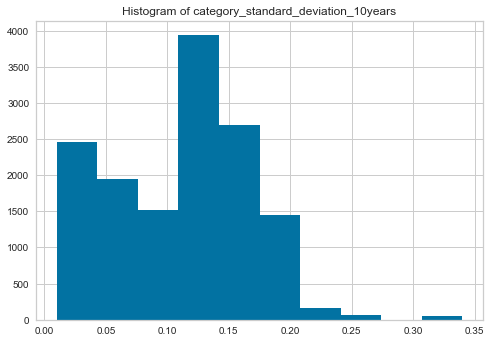

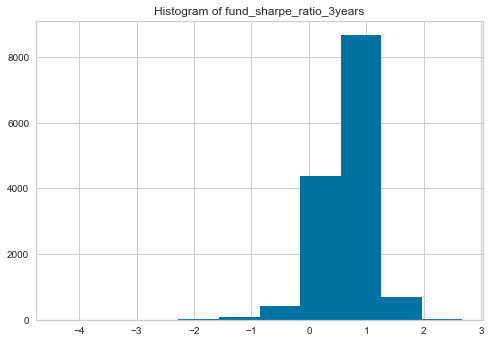

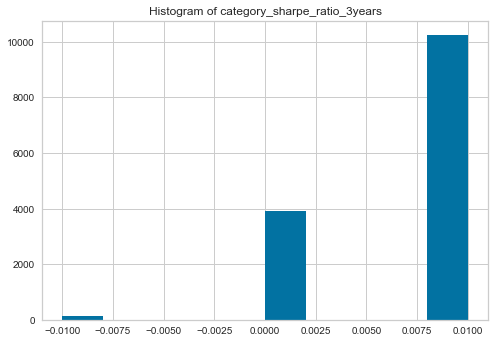

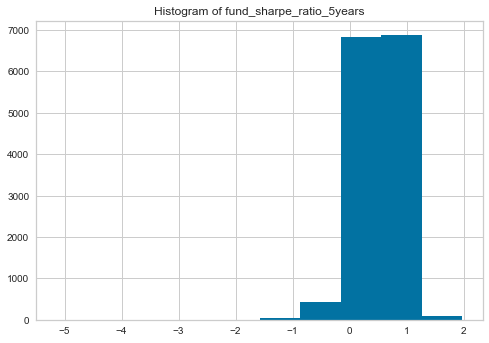

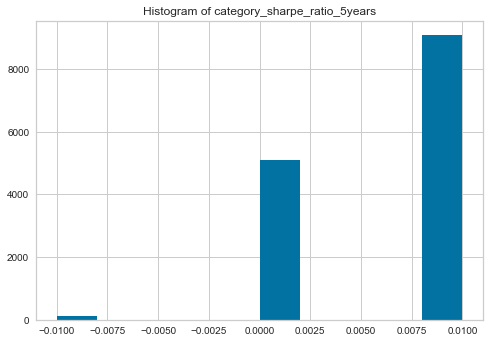

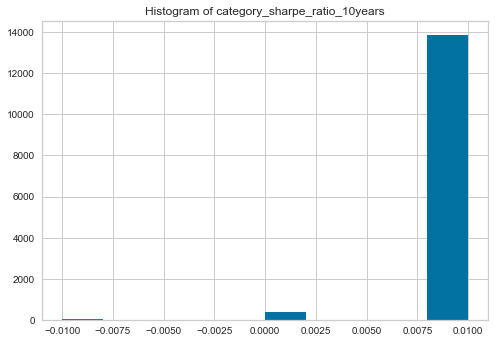

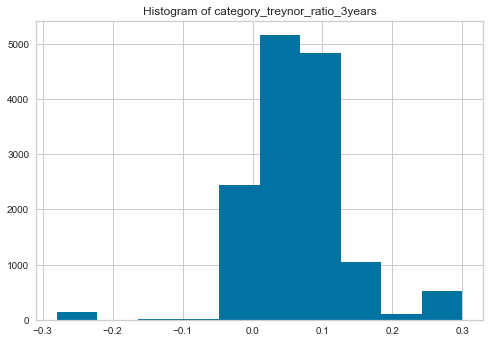

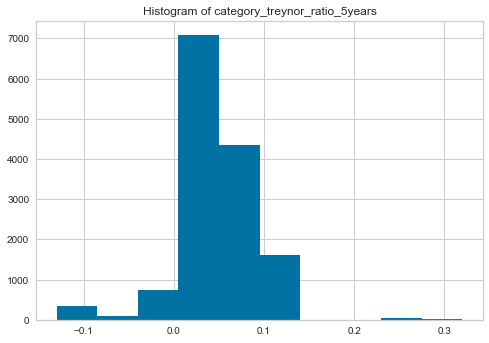

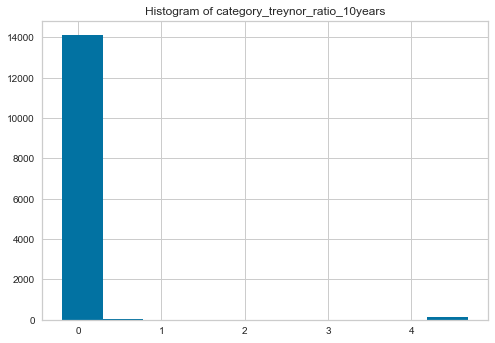

In [74]:

# Plot the histograms of all the variables in the DataFrame.  Plot them all at once using a for loop.  Add unique title.
# for i in df:
#     df[i].hist()
#     plt.title('Histogram of ' + i)
#     plt.show()

In [ ]:
# point plots did not show outliers

In [26]:
plotDf = df.iloc[:, [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 
                    29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 
                    54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 
                    79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]]

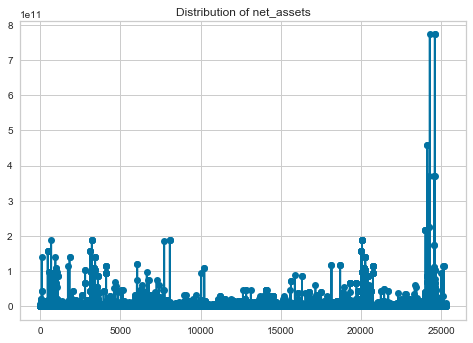

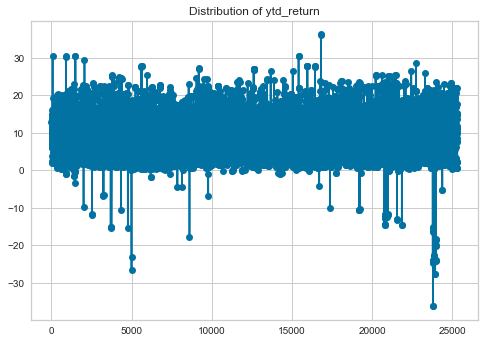

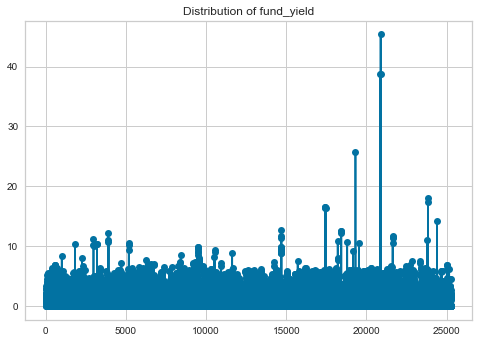

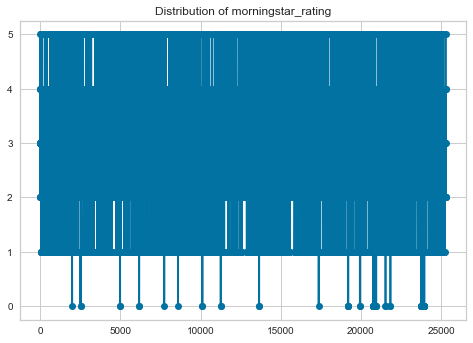

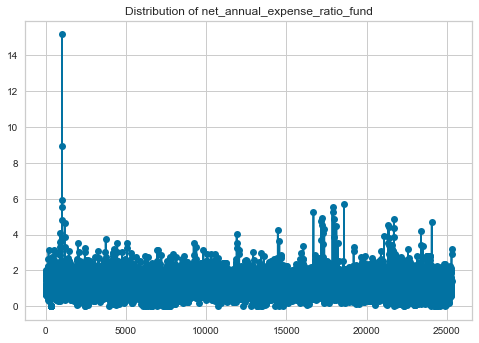

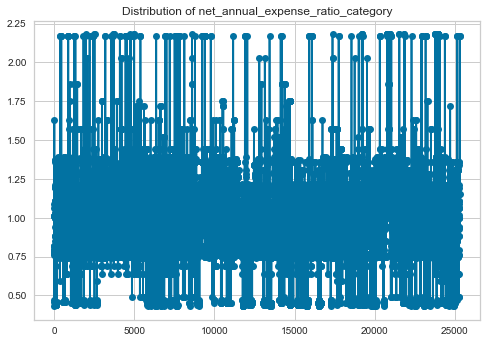

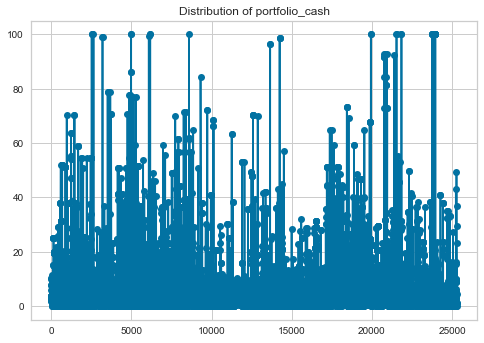

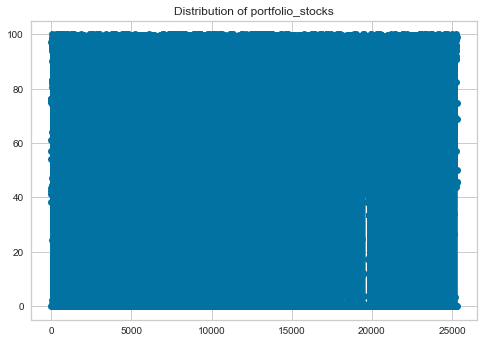

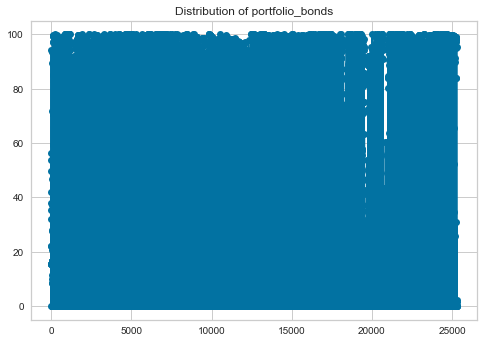

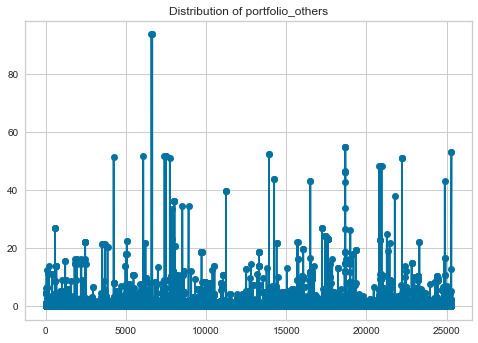

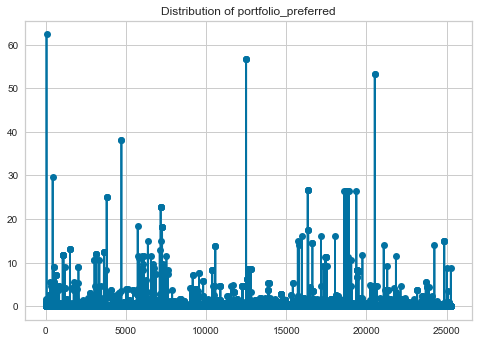

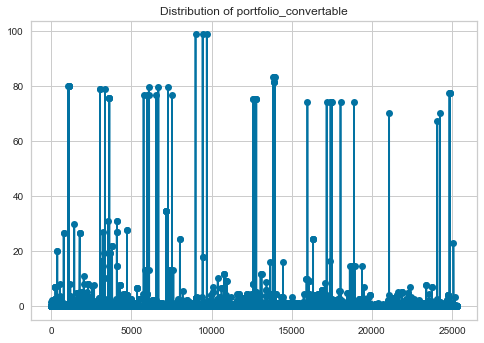

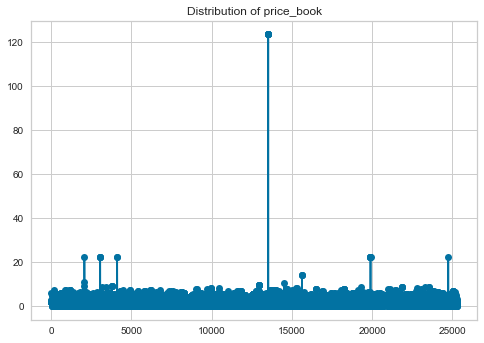

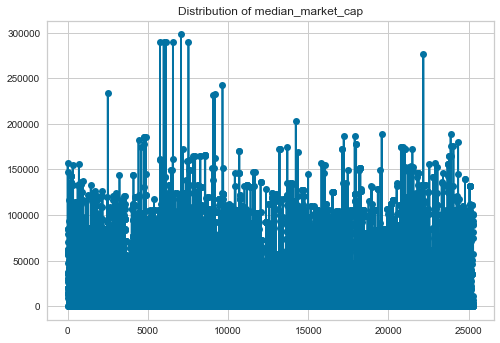

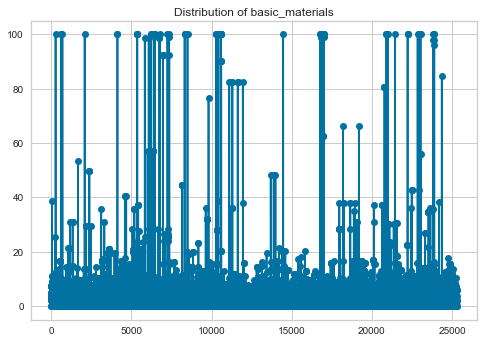

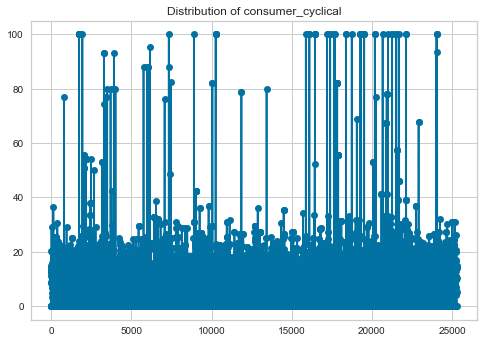

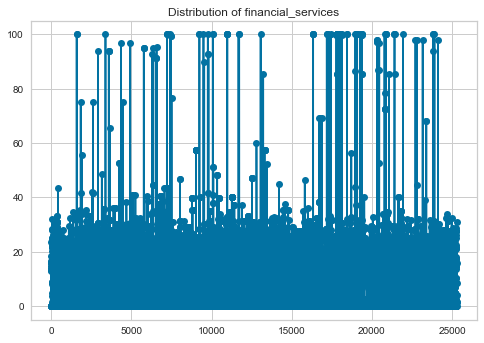

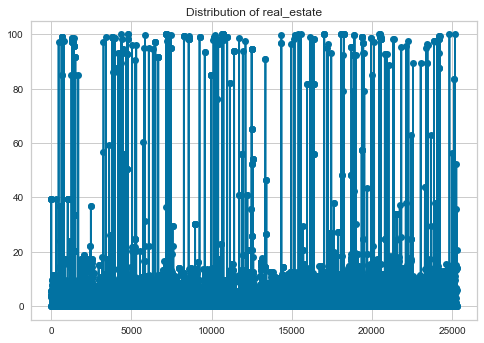

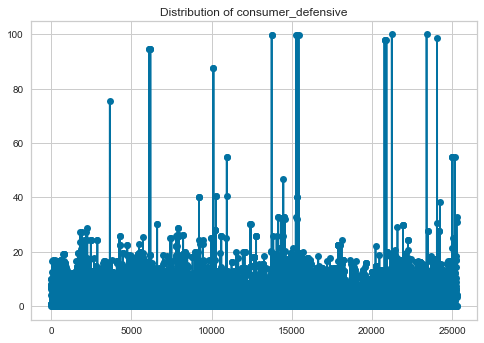

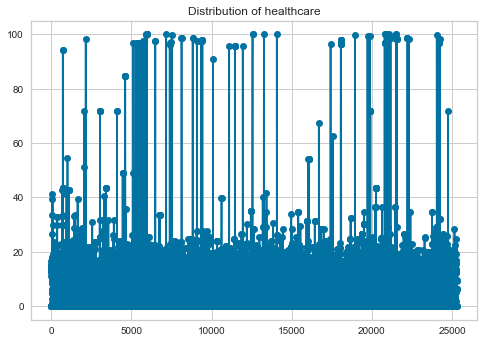

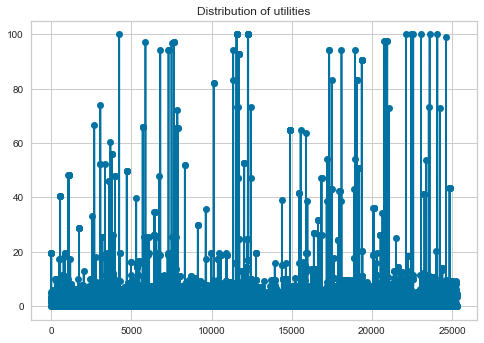

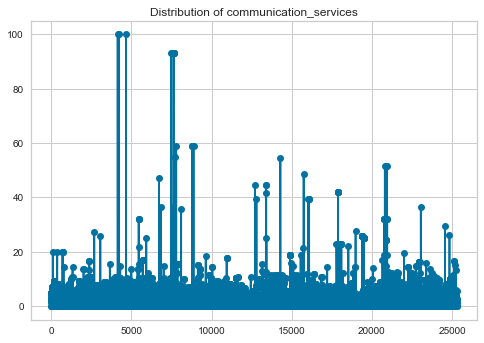

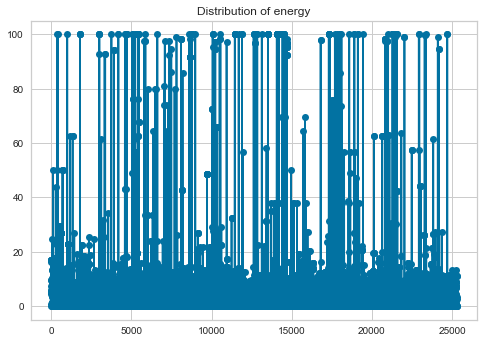

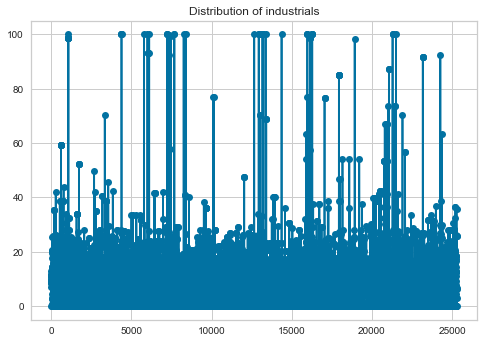

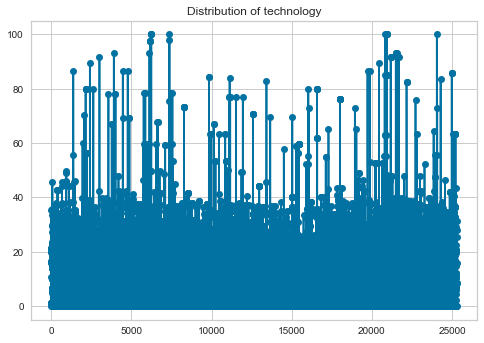

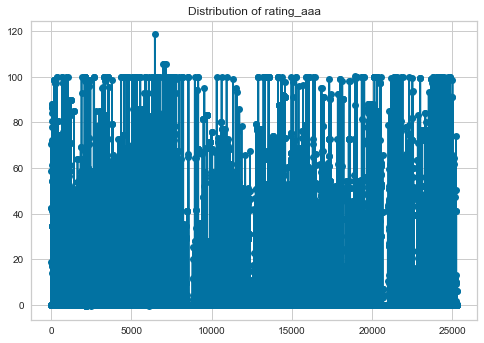

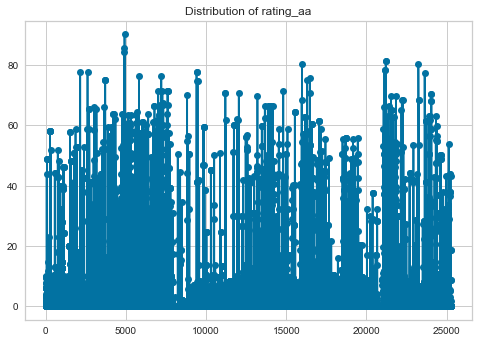

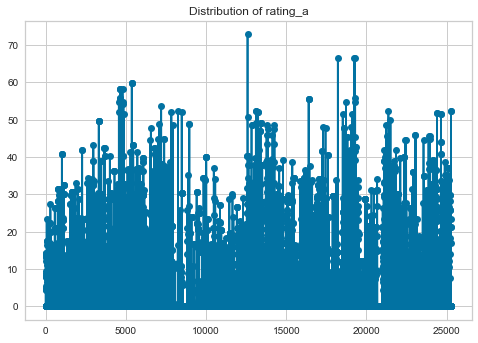

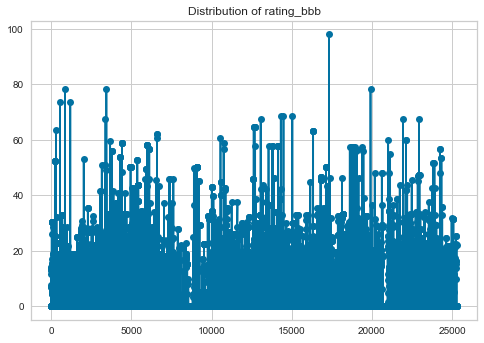

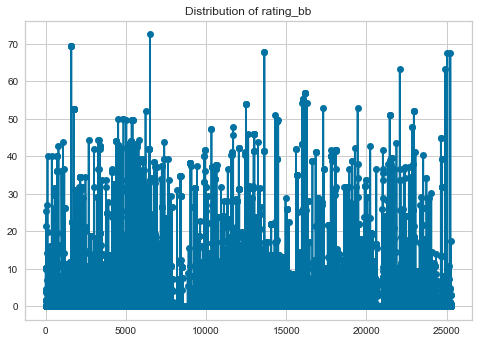

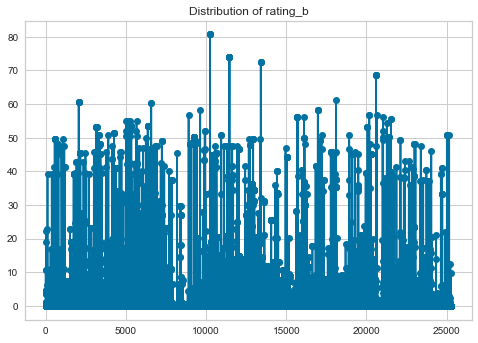

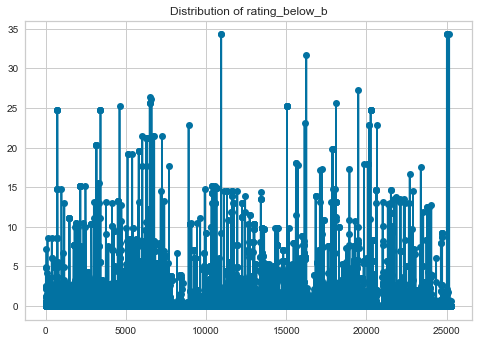

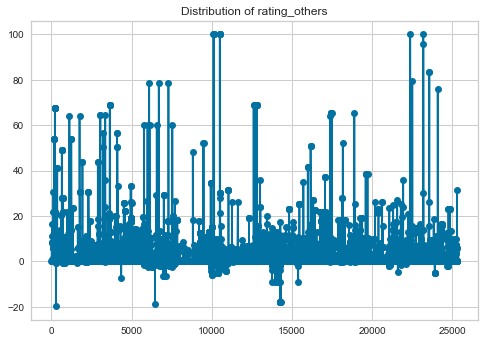

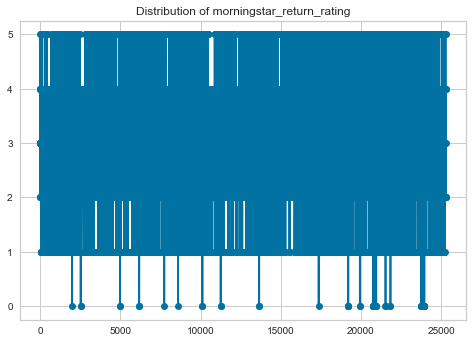

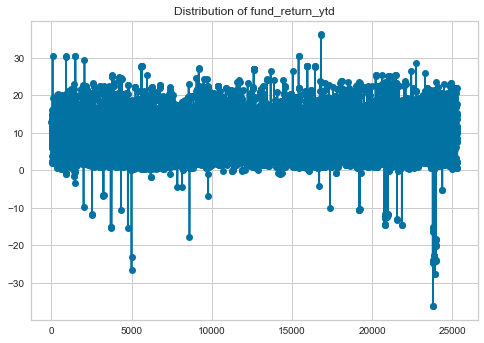

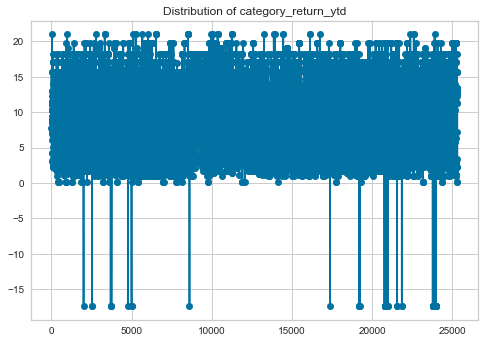

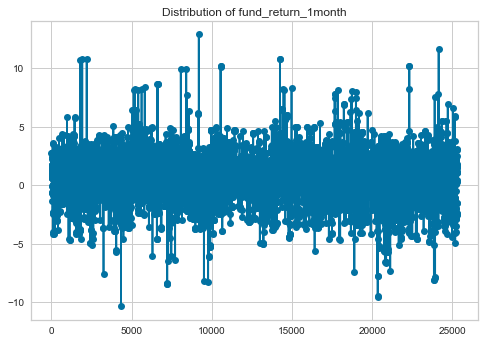

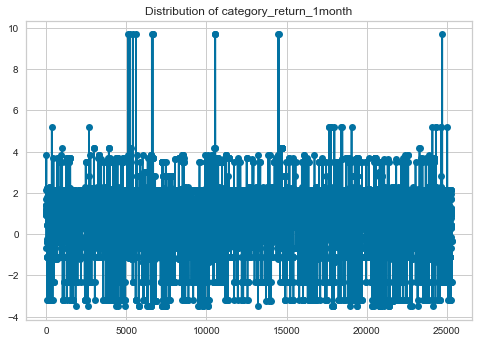

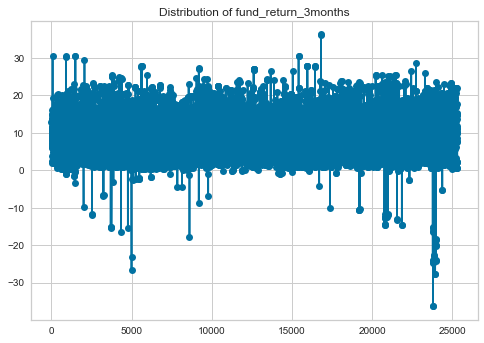

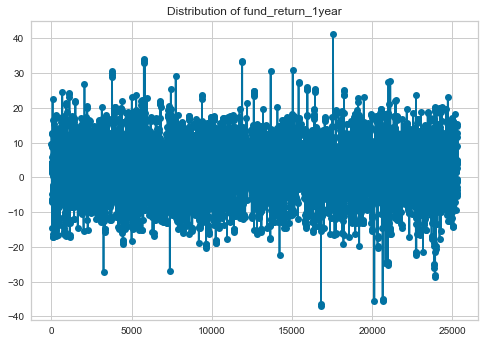

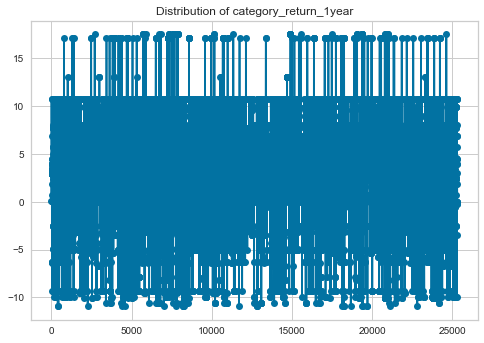

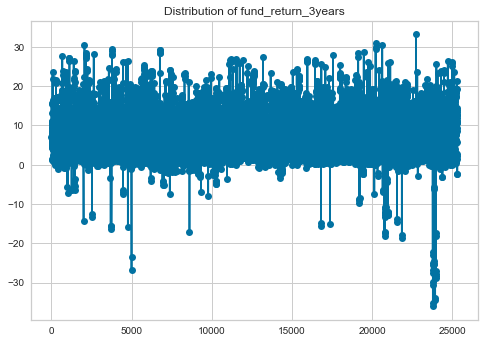

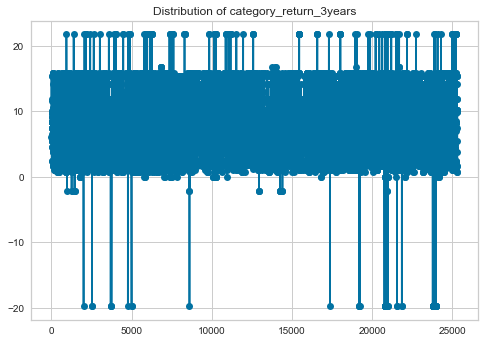

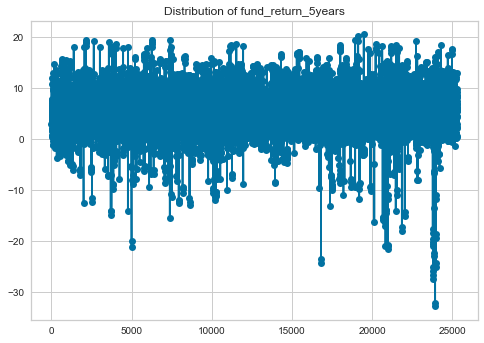

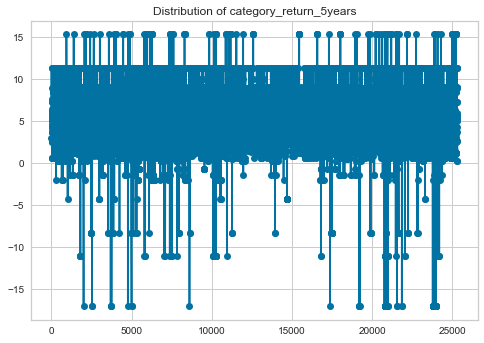

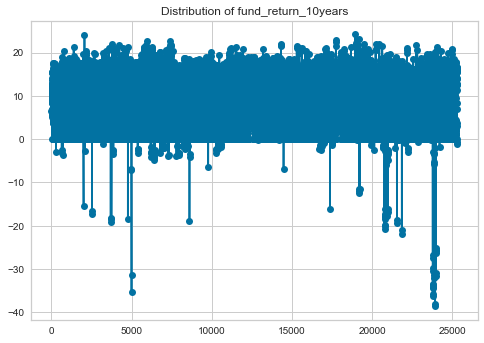

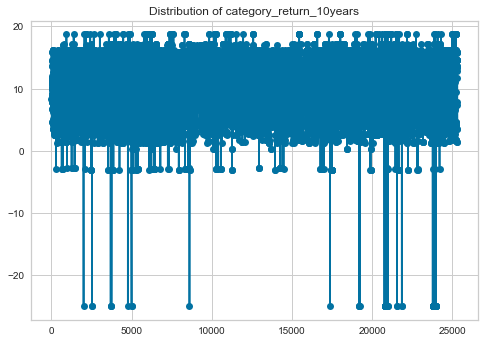

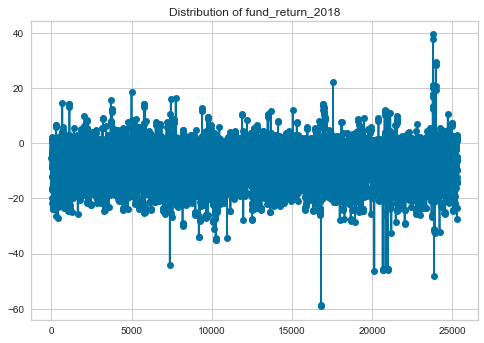

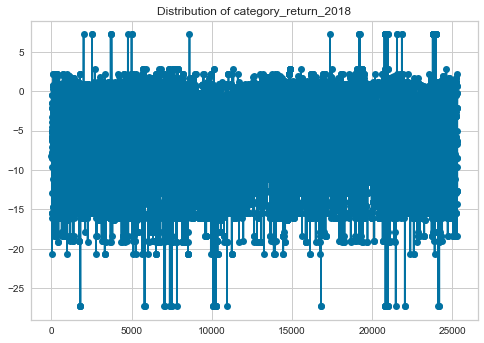

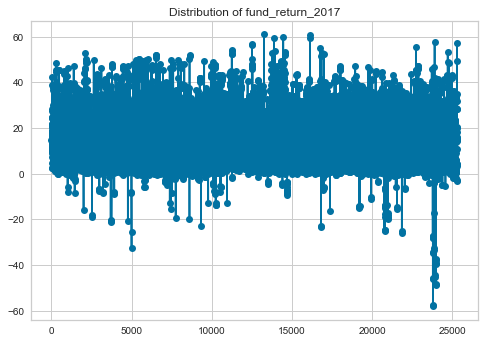

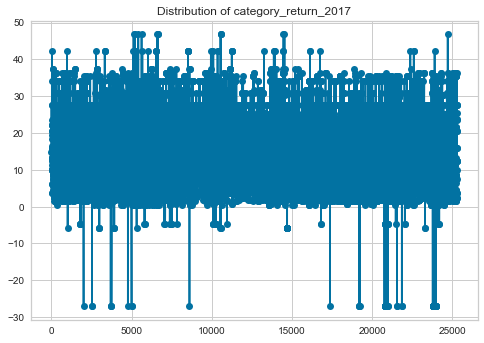

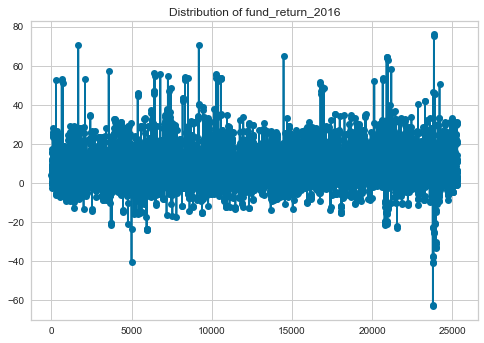

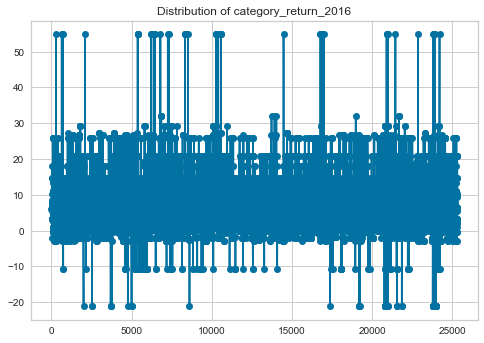

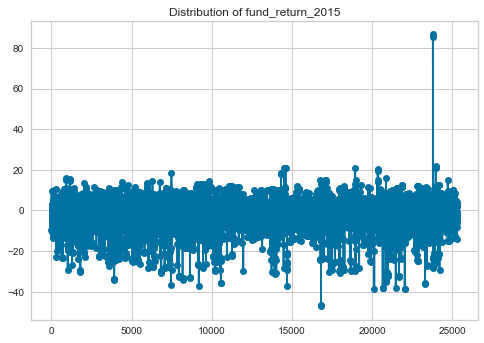

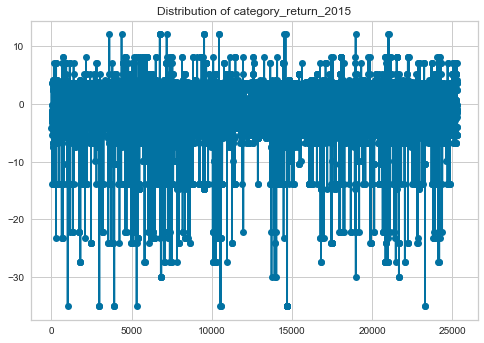

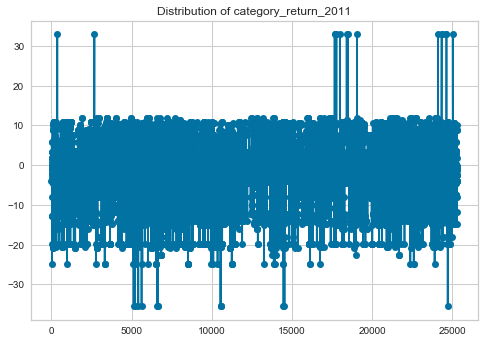

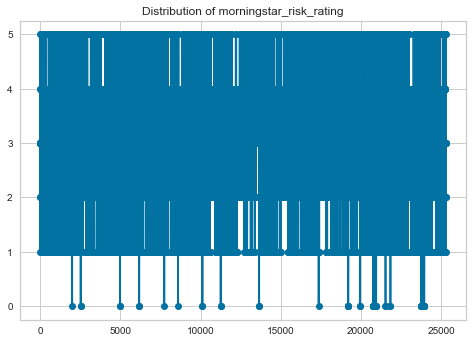

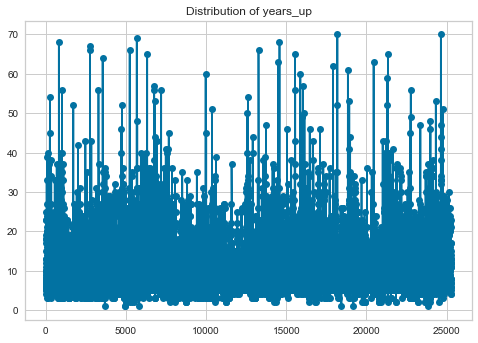

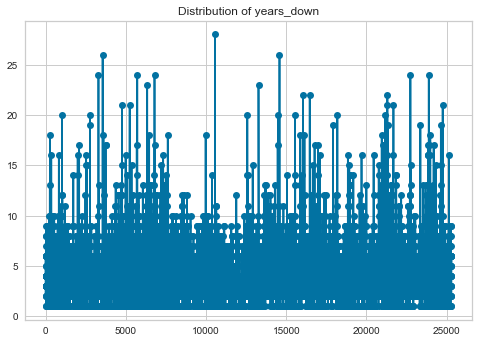

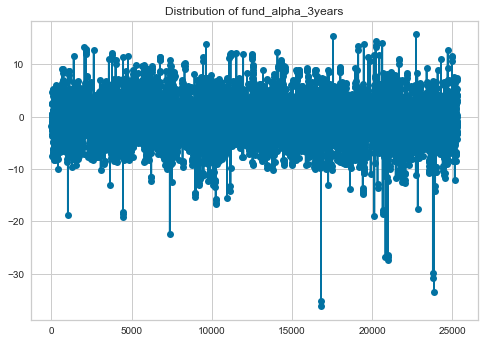

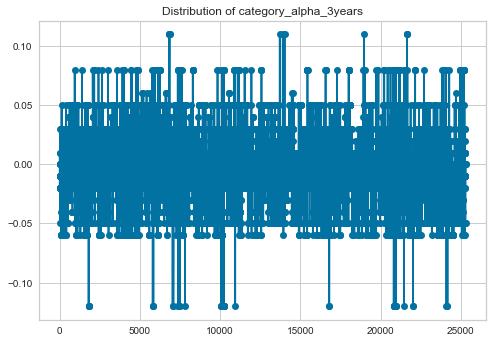

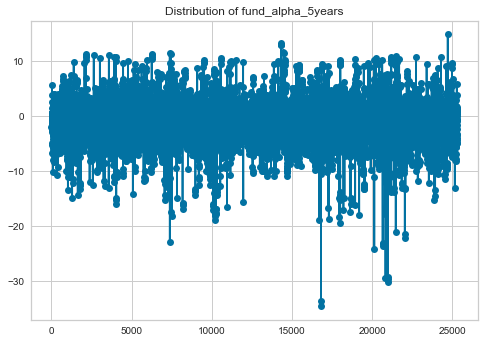

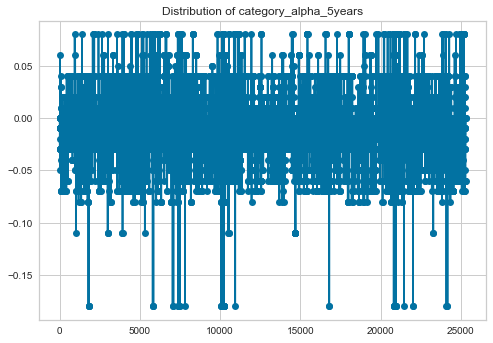

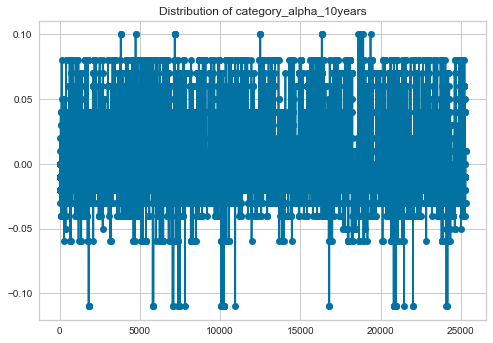

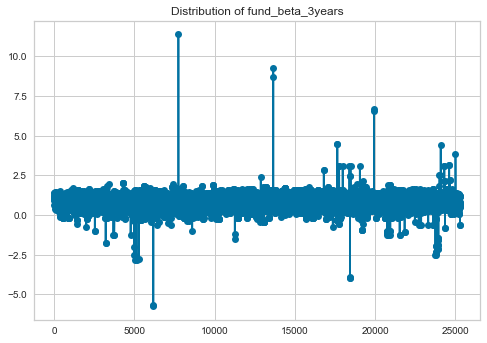

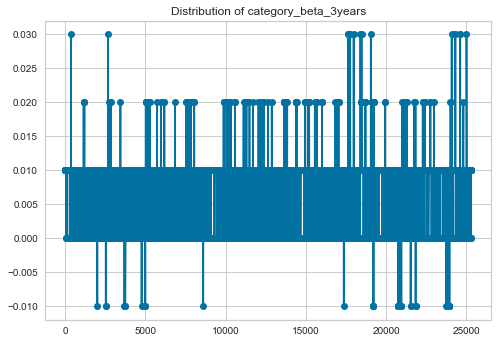

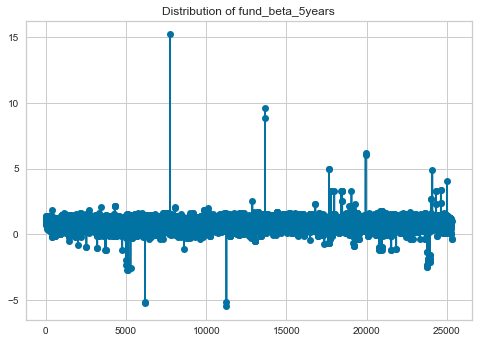

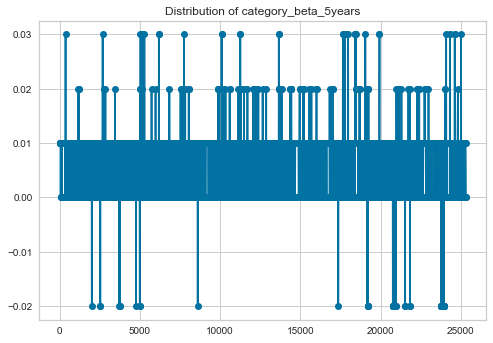

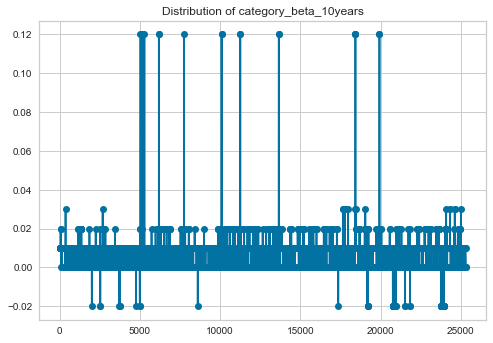

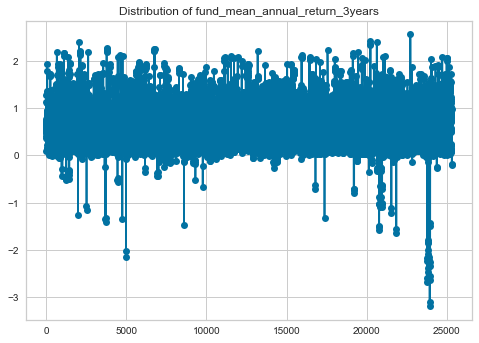

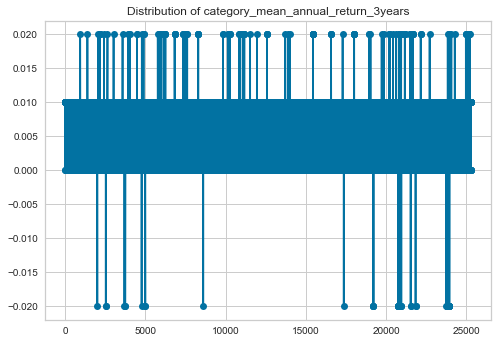

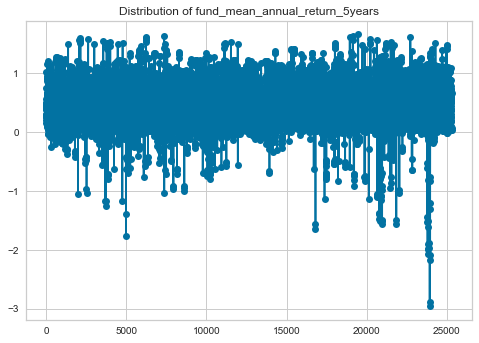

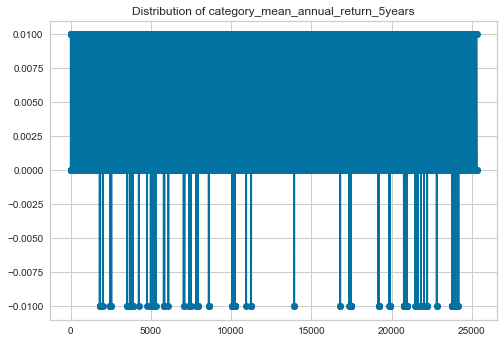

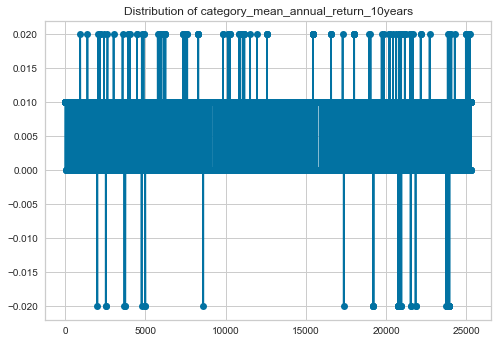

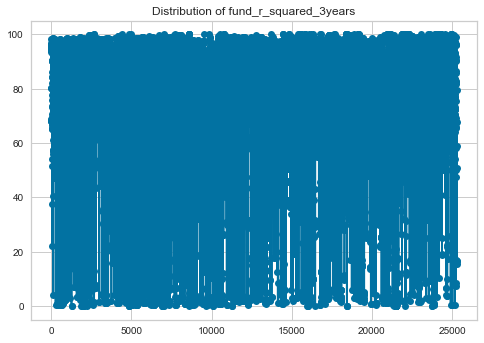

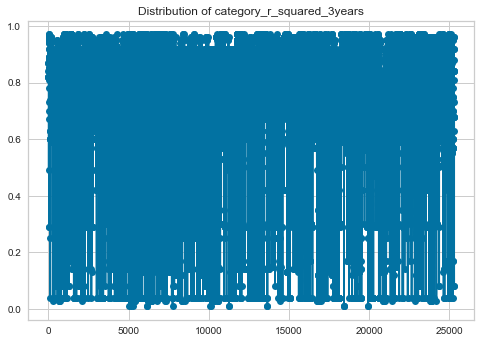

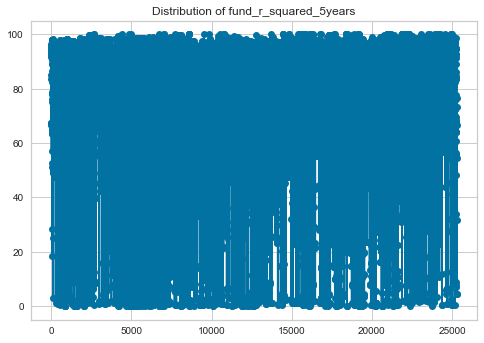

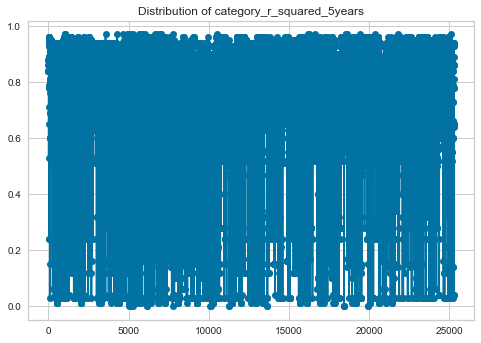

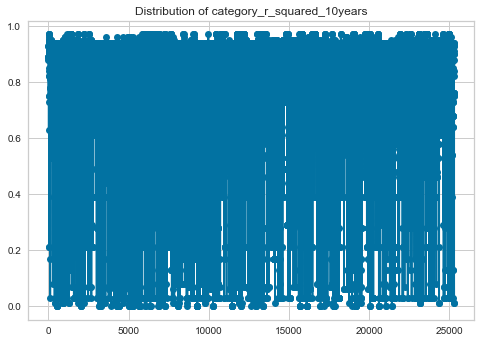

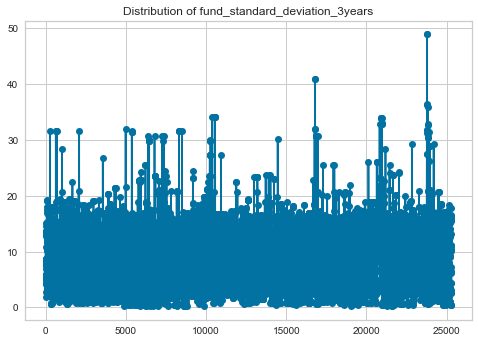

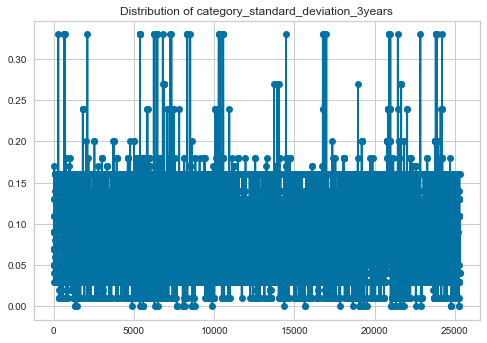

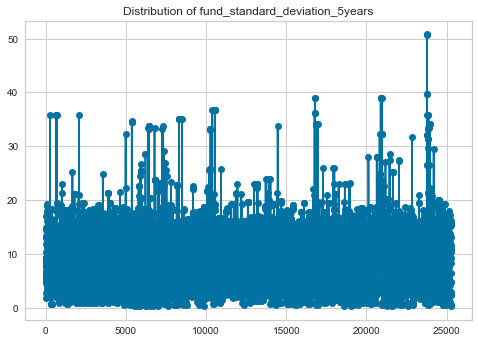

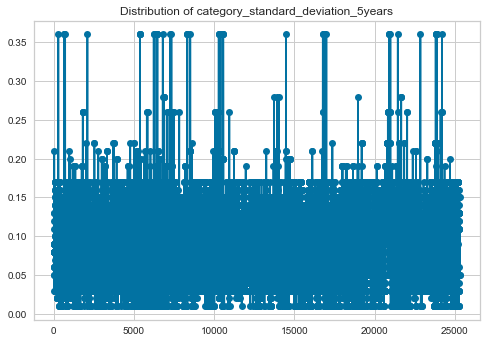

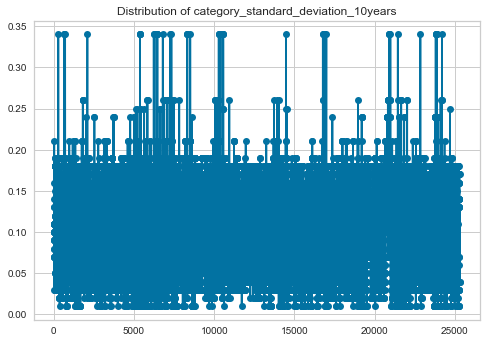

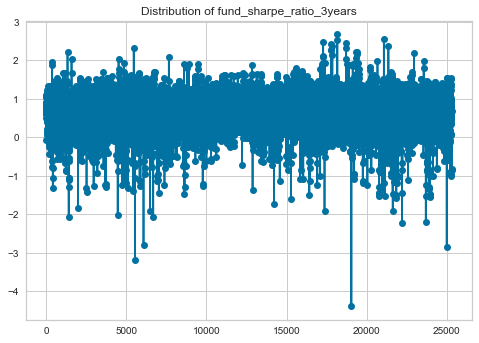

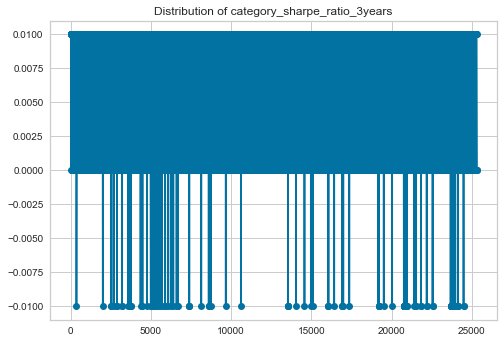

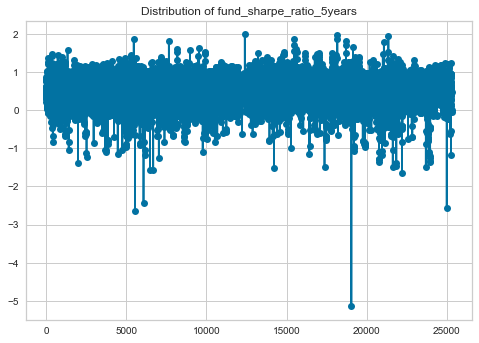

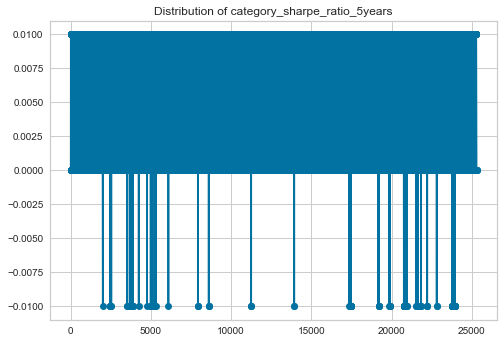

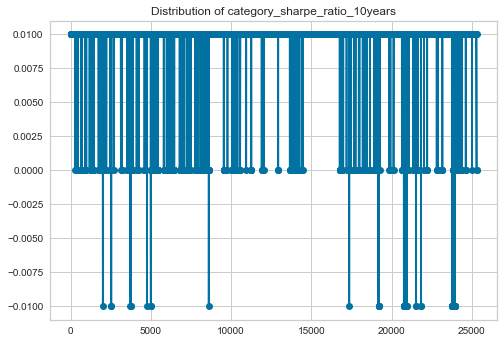

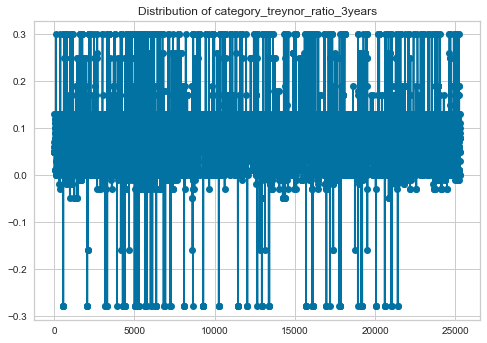

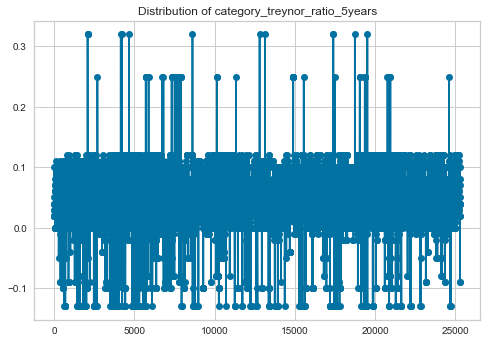

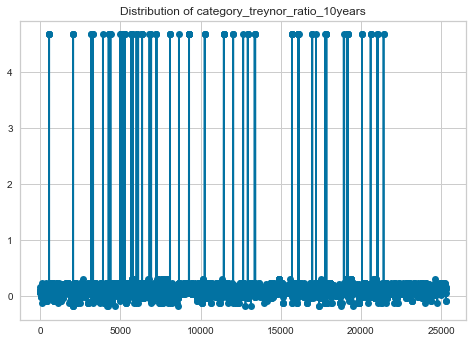

In [27]:
# Plot simple point plots of all the variables in the DataFrame.  Plot them all at once using a for loop.  Add unique title.
#for i in plotDf:
#    df[i].plot(marker='o')
#    plt.title('Distribution of ' + i)
#    plt.show()

> After the data cleaning, I now have 94 features.  After fixing an incorrect data type, 92 of the 94 features are numerical.
The two non-numerical data types are the investment and size features. Most of the features have many unique values because each mutual fund observation has very specific performance data.  These features are not conducive to gaining meaningful interpretations of visualizations.  A few of the numerical features have a limited number of unique values and these are descriptive information about the mutual funds.


In [28]:
# Check what type of variables are in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14292 entries, 0 to 25302
Data columns (total 93 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   net_assets                           14292 non-null  float64
 1   ytd_return                           14292 non-null  float64
 2   fund_yield                           14292 non-null  float64
 3   morningstar_rating                   14292 non-null  int64  
 4   investment                           14292 non-null  object 
 5   size                                 14292 non-null  object 
 6   net_annual_expense_ratio_fund        14292 non-null  float64
 7   net_annual_expense_ratio_category    14292 non-null  float64
 8   portfolio_cash                       14292 non-null  float64
 9   portfolio_stocks                     14292 non-null  float64
 10  portfolio_bonds                      14292 non-null  float64
 11  portfolio_others            

In [17]:
# fix the datatype from object to float
df['median_market_cap'] = df['median_market_cap'].astype(float)

In [18]:
# check shape again
df.shape

(14292, 93)

## Statistics

### Check summary statistics and correlations among features.

> Upon initial review, the summary statistics do not suggest key informative information because most of the features have many unique values because each mutual fund observation has very specific performance data.  The correlation results do give indications of some high correlations with my target variable, as well as other highly correlated variables.


> •	Multiple Pearson Ranking Plots are necessary because of the large number of quantitative features.  •	Each Plot includes the target variable (ytd_return) so that I can see each feature’s correlation with the target variable.  •	The groupings of the other variables in Plots are simply based on the similarity of the type of information in the feature and the goal of limiting the size of each Plot.

In [ ]:
# Check summary statistics and correlations among features.

In [32]:
# Create new datasets with subsets of quantitative variables to better see statistics and correlation results
df_q1 = df.filter(['ytd_return', 'net_assets', 'fund_yield', 'morningstar_rating',
       'net_annual_expense_ratio_fund',
       'net_annual_expense_ratio_category', 'portfolio_cash',
       'portfolio_stocks', 'portfolio_bonds', 'portfolio_others',
       'portfolio_preferred', 'portfolio_convertable', 'price_book'
       ], axis=1)

df_q2 = df.filter(['ytd_return', 'basic_materials', 'consumer_cyclical',
       'financial_services', 'real_estate', 'consumer_defensive', 'healthcare',
       'utilities', 'communication_services', 'energy', 'industrials',
       'technology'], axis=1)

df_q3 = df.filter(['ytd_return', 'rating_aaa', 'rating_aa', 'rating_a', 'rating_bbb',
       'rating_bb', 'rating_b', 'rating_below_b', 'rating_others', 'median_market_cap',
       'morningstar_return_rating', 'category_return_ytd'], axis=1)

df_q4 = df.filter(['ytd_return', 'years_up', 'years_down', 'fund_alpha_3years', 
                   'category_alpha_3years', 'fund_beta_3years', 'category_beta_3years',
                  'fund_mean_annual_return_3years', 'category_mean_annual_return_3years',
                  'fund_r_squared_3years',
       'category_r_squared_3years'], axis=1)

df_q5 = df.filter(['ytd_return', 'fund_standard_deviation_3years', 'category_standard_deviation_3years',
                  'fund_sharpe_ratio_3years', 'category_sharpe_ratio_3years', 'category_treynor_ratio_3years',], axis=1)


In [38]:
# instead of printing each correlation table, use a function to print highest correlation results
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]



In [39]:
# print highest correlation results on each subset of quantitative values
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_q1, 10))

Top Absolute Correlations
portfolio_stocks                   portfolio_bonds                      0.940571
ytd_return                         portfolio_stocks                     0.803151
                                   portfolio_bonds                      0.747886
fund_yield                         portfolio_stocks                     0.556709
                                   portfolio_bonds                      0.538243
ytd_return                         fund_yield                           0.445397
net_annual_expense_ratio_category  portfolio_bonds                      0.430396
portfolio_preferred                portfolio_convertable                0.405254
net_annual_expense_ratio_fund      net_annual_expense_ratio_category    0.366786
morningstar_rating                 net_annual_expense_ratio_fund        0.359562
dtype: float64


In [40]:
# print highest correlation results on each subset of quantitative values
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_q2, 10))

Top Absolute Correlations
ytd_return          technology            0.641670
                    healthcare            0.385779
consumer_cyclical   technology            0.352877
healthcare          technology            0.351416
ytd_return          consumer_cyclical     0.350517
                    industrials           0.297587
financial_services  consumer_defensive    0.252026
ytd_return          financial_services    0.240863
                    consumer_defensive    0.236523
industrials         technology            0.222881
dtype: float64


In [41]:
# print highest correlation results on each subset of quantitative values
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_q3, 10))

Top Absolute Correlations
ytd_return  category_return_ytd    0.931394
rating_bb   rating_b               0.854840
rating_b    rating_below_b         0.772587
rating_aa   rating_a               0.676468
rating_bb   rating_below_b         0.650653
rating_a    rating_bbb             0.627941
            category_return_ytd    0.525483
ytd_return  rating_a               0.495578
rating_aa   category_return_ytd    0.447834
rating_bbb  category_return_ytd    0.445423
dtype: float64


In [42]:
# print highest correlation results on each subset of quantitative values
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_q4, 10))

Top Absolute Correlations
fund_r_squared_3years           category_r_squared_3years             0.907834
ytd_return                      fund_mean_annual_return_3years        0.854298
                                category_mean_annual_return_3years    0.784926
fund_mean_annual_return_3years  category_mean_annual_return_3years    0.749095
fund_alpha_3years               category_alpha_3years                 0.736845
fund_beta_3years                category_beta_3years                  0.667801
category_beta_3years            category_r_squared_3years             0.571604
                                fund_r_squared_3years                 0.523476
ytd_return                      fund_beta_3years                      0.521626
years_up                        years_down                            0.487151
dtype: float64


In [43]:
# print highest correlation results on each subset of quantitative values
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_q5, 10))

Top Absolute Correlations
fund_standard_deviation_3years      category_standard_deviation_3years    0.952106
ytd_return                          fund_standard_deviation_3years        0.724848
                                    category_standard_deviation_3years    0.710981
fund_sharpe_ratio_3years            category_sharpe_ratio_3years          0.658714
ytd_return                          category_sharpe_ratio_3years          0.543477
                                    fund_sharpe_ratio_3years              0.489714
category_sharpe_ratio_3years        category_treynor_ratio_3years         0.414290
fund_sharpe_ratio_3years            category_treynor_ratio_3years         0.381203
ytd_return                          category_treynor_ratio_3years         0.366338
category_standard_deviation_3years  category_treynor_ratio_3years         0.325480
dtype: float64


>

## Visualizations

> Histograms for quantitative variables.


> Because I have so many quantitative variables, I broke up the code and plots so that four histograms per code box displays.  Accordingly, I have repetitive code blocks.

>The target variable of ytd_return shows a roughly normal distribution except for a large spike near 0%.  Most ytd_returns are near zero or between 10%-15%.  The net assets histograms used scientific notation values and will need to be adjusted if I desire to explore that feature.  As discussed above, histograms for these mutual fund quantitative features are not really informative because each fund is dependent on its own performance and not that of other mutual funds.  For example, one fund’s expense ratio does not give insight to another’s performance.


> For previty purposes, I have removed the histograms and bar charts (and their code) that were not helpful.  These were previously submitted in the Part 1 assignment.

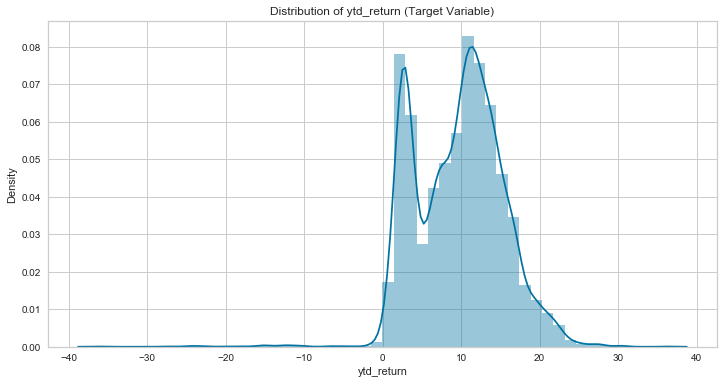

In [33]:
# target variable histogram

import seaborn as sns
plt.figure(figsize=(12, 6))
plt.title("Distribution of ytd_return (Target Variable)")
sns.distplot(df['ytd_return'])

> Pearson Ranking Plots

> Multiple Pearson Ranking Plots are necessary because of the large number of quantitative features.  I created multiple variables for this purpose above.  

> The Pearson Ranking visualizations are helpful to show high correlations with my target variable ytd_return:  portfolio stocks, technology, category return, fund and category 3-year returns, and some of the financial ratio data

> The Pearson Ranking visualizations also show some high correlation among variables that are not my target feature and may be worth examining further.

In [32]:
# Create new feature variables for visualizations

features_q1 = ['ytd_return', 'net_assets', 'fund_yield', 'morningstar_rating',
       'net_annual_expense_ratio_fund',
       'net_annual_expense_ratio_category', 'portfolio_cash',
       'portfolio_stocks', 'portfolio_bonds', 'portfolio_others',
       'portfolio_preferred', 'portfolio_convertable', 'price_book'
       ]

features_q2 = ['ytd_return', 'basic_materials', 'consumer_cyclical', 
       'financial_services', 'real_estate', 'consumer_defensive', 'healthcare',
       'utilities', 'communication_services', 'energy', 'industrials',
       'technology']

features_q3 = ['ytd_return', 'rating_aaa', 'rating_aa', 'rating_a', 'rating_bbb',
       'rating_bb', 'rating_b', 'rating_below_b', 'rating_others',
       'morningstar_return_rating', 'category_return_ytd']

features_q4 = ['ytd_return', 'years_up', 'years_down', 'fund_alpha_3years', 
                   'category_alpha_3years', 'fund_beta_3years', 'category_beta_3years',
                  'fund_mean_annual_return_3years', 'category_mean_annual_return_3years',
                  'fund_r_squared_3years', 'category_r_squared_3years']

features_q5 = ['ytd_return', 'fund_standard_deviation_3years', 'category_standard_deviation_3years',
                  'fund_sharpe_ratio_3years', 'category_sharpe_ratio_3years', 'category_treynor_ratio_3years']


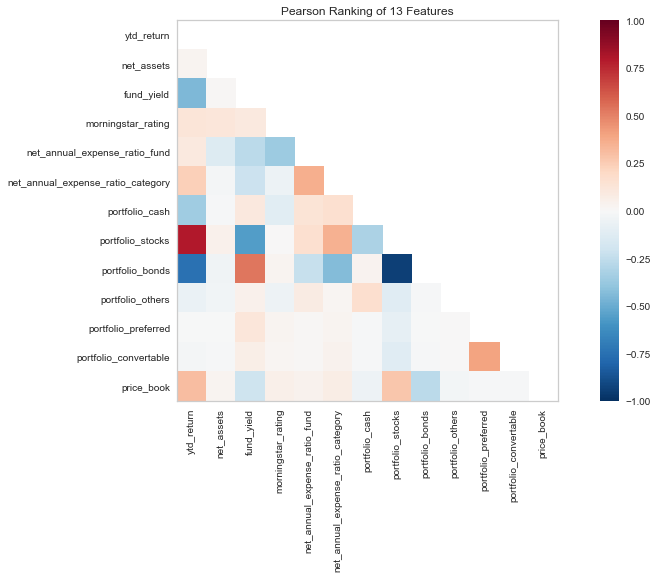

In [64]:
# First Pearson Ranking plot

#set up the figure size
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

# extract the numpy arrays from the data frame
X =df[features_q1].to_numpy()

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=features_q1, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof(outpath="d://pcoords1.png") # Draw/show/poof the data
#plt.show()


> Examine the high correlation of the target and "portfolio_stocks".

"portfolio_stocks" is highly correlated with "ytd_return". This feature can be actually be known without knowing the target "ytd_return" and thus it is valid to assume that we could actually know "portfolio_stocks" for a prediction.  In order to confirm the following will do a simple regression between just portfolio_stocks and the target ytd_return

In [11]:

# create a portfolio_stocks dataset that can be used for train and validation data splitting
PS = df['portfolio_stocks']
ytd = df['ytd_return']

# separate data into training and validation 
PSTrain, PSTest, yTrain_PS, yTest_PS = train_test_split(PS, y, test_size =0.3, random_state=11)

# Instantiate the linear regression model using default parameters
olsPortf_stocks = LinearRegression()

# Fit the model with training data
olsPortf_stocks.fit(PSTrain[:, np.newaxis], yTrain_PS[:, np.newaxis])

# evaluate the baseline with the r-squared score
print(olsPortf_stocks.score(PSTest[:, np.newaxis], yTest_PS[:, np.newaxis]))

0.7032011004714277


> This basic regression model shows that 70% of the portfolio_stock data fits the regression model. This is a fairly good fit, but probably not large enough to indicate that variables are dependent on each other.

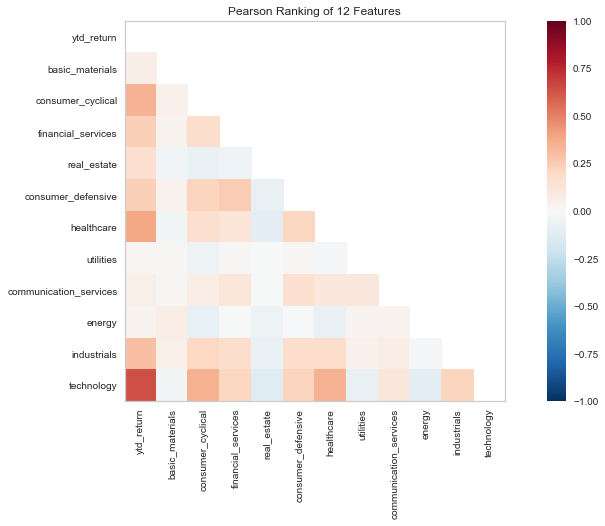

In [65]:
# Second Pearson Ranking plot

#Pearson Ranking
#set up the figure size
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

# extract the numpy arrays from the data frame
X =df[features_q2].to_numpy()

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=features_q2, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof(outpath="d://pcoords1.png") # Draw/show/poof the data
#plt.show()

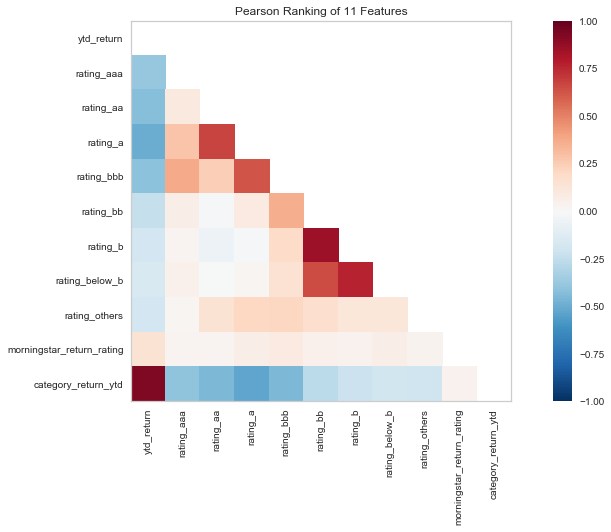

In [66]:
# Third Pearson Ranking plot

# Pearson Ranking
#set up the figure size
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

# extract the numpy arrays from the data frame
X =df[features_q3].to_numpy()

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=features_q3, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof(outpath="d://pcoords1.png") # Draw/show/poof the data
#plt.show()

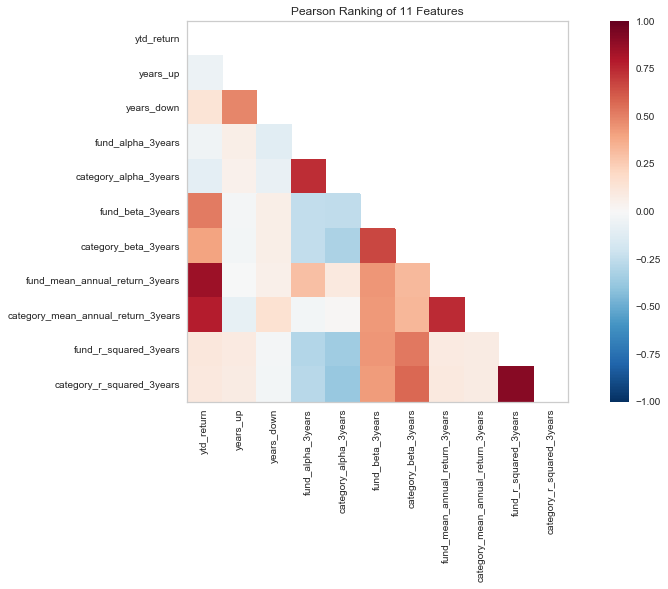

In [67]:
# Fourth Pearson Ranking plot

# Pearson Ranking
#set up the figure size
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

# extract the numpy arrays from the data frame
X =df[features_q4].to_numpy()

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=features_q4, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof(outpath="d://pcoords1.png") # Draw/show/poof the data
#plt.show()

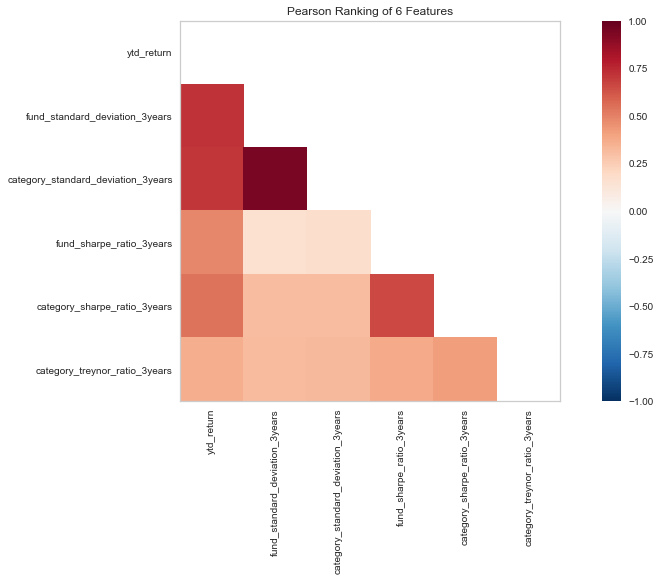

In [68]:
# Fifth Pearson Ranking plot

#Pearson Ranking
#set up the figure size
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

# extract the numpy arrays from the data frame
X =df[features_q5].to_numpy()

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=features_q5, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof(outpath="d://pcoords1.png") # Draw/show/poof the data
#plt.show()

### Can grouping variables aid in graph analysis?

> The two categorical features seem like informative candidates for grouping.

In [ ]:
# Groupby

In [34]:
invGr = df.groupby('investment')['ytd_return'].count()
invGr.head()

investment
Blend     5674
FILL       666
Growth    4210
Value     3742
Name: ytd_return, dtype: int64

In [35]:
sizeGr = df.groupby('size')['ytd_return'].count()
sizeGr.head()

size
FILL       666
Large     8090
Medium    3666
Small     1870
Name: ytd_return, dtype: int64

The grouby results for investent and size helped me determine that the missing values counts for each are 666 and that the same 666 records have missing values in each of the two records.


In [19]:
# drop the records with missing size and investment records
df = df[df['size'] != 'FILL']

In [20]:
df.shape

(13626, 93)

In [22]:
sizeGr = df.groupby('size')['ytd_return'].count()
sizeGr.head()

size
Large     8090
Medium    3666
Small     1870
Name: ytd_return, dtype: int64

In [23]:
invGr = df.groupby('investment')['ytd_return'].count()
invGr.head()

investment
Blend     5674
Growth    4210
Value     3742
Name: ytd_return, dtype: int64

In [24]:
invGr = df.groupby('investment')['ytd_return'].agg(['count', 'mean', 'std', 'max'])
invGr.head()

count       mean       std    max
investment                                   
Blend        5674   8.714143  4.495617  36.26
Growth       4210  13.654653  5.189822  30.58
Value        3742   7.860880  4.668040  21.07

[Text(0, 0.5, 'Mean YTD Return'),
 Text(0.5, 0, 'Investment'),
 Text(0.5, 1.0, "Average Year-to-Date Return Grouped by the Mutual Fund's Investment Type")]

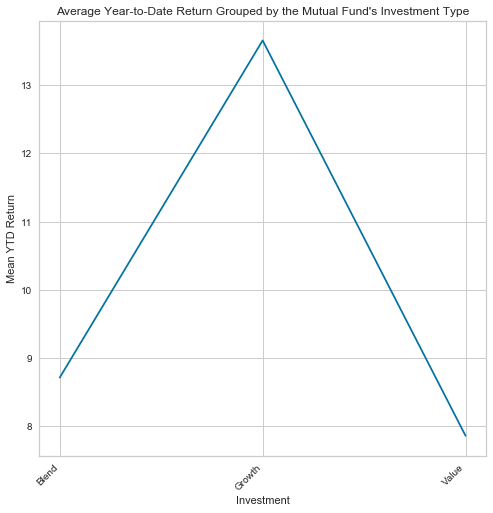

In [244]:
# plot of mean of the target (ytd_return) grouped by size categorical feature

# set up the figure size
fig, ax = plt.subplots(figsize=(8, 8))

# make the data read to feed into the visulizer
invGrMean = df.groupby('investment')['ytd_return'].mean()

# set components of bar plot
ax.plot(invGrMean)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(xlabel='Investment', ylabel='Mean YTD Return',
       title="Average Year-to-Date Return Grouped by the Mutual Fund's Investment Type")

[Text(0, 0.5, 'Mean YTD Return'),
 Text(0.5, 0, 'Size'),
 Text(0.5, 1.0, "Average Year-to-Date Return Grouped by the Mutual Fund's Size of Holdings")]

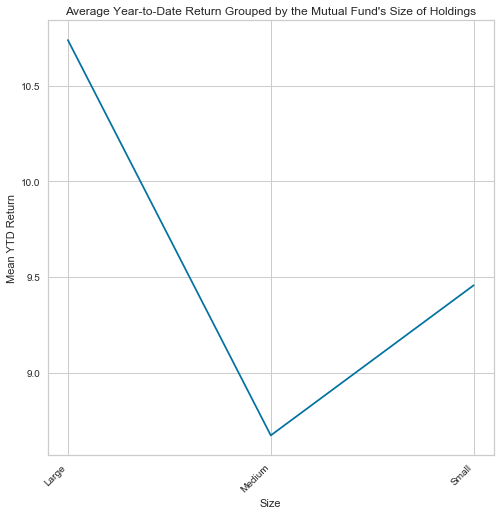

In [245]:
# plot of mean of the target (ytd_return) grouped by size categorical feature

# set up the figure size
fig, ax = plt.subplots(figsize=(8, 8))

# make the data read to feed into the visulizer
sizeGrMean = df.groupby('size')['ytd_return'].mean()

# set components of bar plot
ax.plot(sizeGrMean)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(xlabel='Size', ylabel='Mean YTD Return',
       title="Average Year-to-Date Return Grouped by the Mutual Fund's Size of Holdings")

In [246]:
categGrMean = df.groupby(['size', 'investment'])['ytd_return'].mean()
categGrMean.head(10)

size    investment
Large   Blend          9.388108
        Growth        13.777267
        Value          9.057437
Medium  Blend          6.788438
        Growth        13.718438
        Value          6.231276
Small   Blend          9.643333
        Growth        12.873972
        Value          7.270000
Name: ytd_return, dtype: float64

> These visualizations show a difference in means in the target variable between the investment and size categories.

## Data Preparation continued

> Adjust skewed data.

In [25]:
df.shape

(13626, 93)

In [26]:
# log-transformation


def log_transformation(data):
    return data.apply(np.log1p)

df['net_annual_expense_ratio_category'] = log_transformation(df['net_annual_expense_ratio_category'])
df['portfolio_cash'] = log_transformation(df['portfolio_cash'])
df['portfolio_others'] = log_transformation(df['portfolio_others'])
df['portfolio_preferred'] = log_transformation(df['portfolio_preferred'])
df['portfolio_convertable'] = log_transformation(df['portfolio_convertable'])
df['basic_materials'] = log_transformation(df['basic_materials'])
df['consumer_cyclical'] = log_transformation(df['consumer_cyclical'])
df['financial_services'] = log_transformation(df['financial_services'])
df['real_estate'] = log_transformation(df['real_estate'])
df['consumer_defensive'] = log_transformation(df['consumer_defensive'])
df['healthcare'] = log_transformation(df['healthcare'])
df['utilities'] = log_transformation(df['utilities'])
df['communication_services'] = log_transformation(df['communication_services'])
df['energy'] = log_transformation(df['energy'])
df['industrials'] = log_transformation(df['industrials'])
df['technology'] = log_transformation(df['technology'])
df['rating_aaa'] = log_transformation(df['rating_aaa'])
df['rating_aa'] = log_transformation(df['rating_aa'])
df['rating_a'] = log_transformation(df['rating_a'])
df['rating_bbb'] = log_transformation(df['rating_bbb'])
df['rating_bb'] = log_transformation(df['rating_bb'])
df['rating_b'] = log_transformation(df['rating_b'])
df['rating_below_b'] = log_transformation(df['rating_below_b'])
df['rating_others'] = log_transformation(df['rating_others'])
df['category_return_ytd'] = log_transformation(df['category_return_ytd'])
df['category_return_1month'] = log_transformation(df['category_return_1month'])
df['fund_return_3months'] = log_transformation(df['fund_return_3months'])
df['category_return_3years'] = log_transformation(df['category_return_3years'])
df['fund_return_5years'] = log_transformation(df['fund_return_5years'])
df['category_return_5years'] = log_transformation(df['category_return_5years'])
df['fund_return_10years'] = log_transformation(df['fund_return_10years'])
df['category_return_10years'] = log_transformation(df['category_return_10years'])
df['category_return_2017'] = log_transformation(df['category_return_2017'])
df['years_down'] = log_transformation(df['years_down'])
df['years_up'] = log_transformation(df['years_up'])
df['fund_standard_deviation_3years'] = log_transformation(df['fund_standard_deviation_3years'])
df['category_standard_deviation_3years'] = log_transformation(df['category_standard_deviation_3years'])
df['fund_standard_deviation_5years'] = log_transformation(df['fund_standard_deviation_5years'])
df['category_standard_deviation_5years'] = log_transformation(df['category_standard_deviation_5years'])
df['category_standard_deviation_10years'] = log_transformation(df['category_standard_deviation_10years'])


In [27]:
for c in df.columns:
    miss = df[c].isnull().sum()
    if miss>0:
        print("{} has {} missing value(s)".format(c,miss))

rating_others has 172 missing value(s)
category_return_ytd has 18 missing value(s)
category_return_1month has 1310 missing value(s)
fund_return_3months has 43 missing value(s)
category_return_3years has 27 missing value(s)
fund_return_5years has 371 missing value(s)
category_return_5years has 226 missing value(s)
fund_return_10years has 97 missing value(s)
category_return_10years has 93 missing value(s)
category_return_2017 has 85 missing value(s)


**Needed to rearrange columns for further coding steps.**

In [289]:
# rearrange order of columns
cols = df.columns.tolist()


In [28]:
df.shape

(13626, 93)

In [29]:
df = df[['ytd_return',
 'fund_yield',
 'morningstar_rating',
 'net_annual_expense_ratio_fund',
 'net_annual_expense_ratio_category',
 'portfolio_cash',
 'portfolio_stocks',
 'portfolio_bonds',
 'portfolio_others',
 'portfolio_preferred',
 'portfolio_convertable',
 'price_book',
 'median_market_cap',
 'basic_materials',
 'consumer_cyclical',
 'financial_services',
 'real_estate',
 'consumer_defensive',
 'healthcare',
 'utilities',
 'communication_services',
 'energy',
 'industrials',
 'technology',
 'rating_aaa',
 'rating_aa',
 'rating_a',
 'rating_bbb',
 'rating_bb',
 'rating_b',
 'rating_below_b',
 'rating_others',
 'morningstar_return_rating',
 'category_return_ytd',
 'fund_return_1month',
 'category_return_1month',
 'fund_return_3months',
 'fund_return_1year',
 'category_return_1year',
 'fund_return_3years',
 'category_return_3years',
 'fund_return_5years',
 'category_return_5years',
 'fund_return_10years',
 'category_return_10years',
 'fund_return_2018',
 'category_return_2018',
 'fund_return_2017',
 'category_return_2017',
 'fund_return_2016',
 'category_return_2016',
 'fund_return_2015',
 'category_return_2015',
 'category_return_2011',
 'morningstar_risk_rating',
 'years_up',
 'years_down',
 'fund_alpha_3years',
 'category_alpha_3years',
 'fund_alpha_5years',
 'category_alpha_5years',
 'category_alpha_10years',
 'fund_beta_3years',
 'category_beta_3years',
 'fund_beta_5years',
 'category_beta_5years',
 'category_beta_10years',
 'fund_mean_annual_return_3years',
 'category_mean_annual_return_3years',
 'fund_mean_annual_return_5years',
 'category_mean_annual_return_5years',
 'category_mean_annual_return_10years',
 'fund_r_squared_3years',
 'category_r_squared_3years',
 'fund_r_squared_5years',
 'category_r_squared_5years',
 'category_r_squared_10years',
 'fund_standard_deviation_3years',
 'category_standard_deviation_3years',
 'fund_standard_deviation_5years',
 'category_standard_deviation_5years',
 'category_standard_deviation_10years',
 'fund_sharpe_ratio_3years',
 'category_sharpe_ratio_3years',
 'fund_sharpe_ratio_5years',
 'category_sharpe_ratio_5years',
 'category_sharpe_ratio_10years',
 'category_treynor_ratio_3years',
 'category_treynor_ratio_5years',
 'category_treynor_ratio_10years',
 'net_assets',
 'investment',
 'size']]

**Log transformation must have added missing values.**

In [30]:
# log transformation added missing values
# drop rows with missing values because cannot impute values from other mutual fund data to predict target mutual fund 
df = df.dropna(axis = 0, how ='any')

In [31]:
df.shape

(11801, 93)

In [32]:
for c in df.columns:
    miss = df[c].isnull().sum()
    if miss>0:
        print("{} has {} missing value(s)".format(c,miss))

**A few preparations for PCA and modeling.**

In [34]:
# ratings_others have problem values; need to drop infinite values
df = df[np.isfinite(df['rating_others'])]

In [35]:
df.shape

(11796, 93)

In [36]:
for c in df.columns:
    miss = df[c].isnull().sum()
    if miss>0:
        print("{} has {} missing value(s)".format(c,miss))

In [44]:
# reset the index on the df dataframe before PCA analysis
df.reset_index(drop=True, inplace=True)

In [45]:
df.shape

(11796, 93)

In [46]:
print(df['ytd_return'])

0        12.79
1        16.00
2        11.57
3        12.53
4        12.71
         ...  
11791    13.57
11792     2.23
11793     7.77
11794     8.72
11795     0.53
Name: ytd_return, Length: 11796, dtype: float64


**Need to scale features for modeling purposes because of of the wide ranges of values and because PCA analysis requires scaling of features.**

In [47]:
# designate the features to be used in the PCA
qPredictors = df.iloc[:, 1:91]

In [48]:
# scale the features making the mean zero and standard deviation 1 along each feature be used in the PCA
features= StandardScaler().fit_transform(qPredictors)

## Dimensionality Reduction.

### PCA:  Some of the variables are highly correlated to a great extent and there are still a great many features. Conduct PCA analysis for dimensionalty reduction and to address multicollinearity.

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [50]:
# set the amount of PCA components
pca=PCA(n_components=0.99, whiten=True)

In [51]:
# fit PCA function to numeric features
features_pca = pca.fit_transform(features)

In [52]:
print("original number of features:", features.shape[1])

original number of features: 90


In [53]:
print("reduced number of features:", features_pca.shape[1])

reduced number of features: 57


In [54]:
# create new dataframe with PCA features
pcaDf = pd.DataFrame(data = features_pca)

In [55]:
pcaDf.shape

(11796, 57)

In [56]:
pcaDf.head()

0         1         2         3         4         5         6   \
0 -0.164142 -0.627431  0.748711 -0.004062 -0.328205  0.120679  0.737548   
1 -1.005503  0.927762 -1.640637 -0.575510 -0.089121 -0.173229 -1.323291   
2 -0.317525 -0.464750 -0.294273  1.427644  1.009456 -0.382709  0.702505   
3 -0.158236 -0.807338  0.970735 -0.208629 -0.706570 -0.696112  0.230027   
4 -0.151244 -0.666399  0.791558 -0.011537 -0.356627  0.110287  0.569995   

         7         8         9   ...        47        48        49        50  \
0  2.413326  0.630328  0.591377  ...  1.661563 -2.833707 -0.715034 -0.994826   
1 -1.142051  0.131654  0.753706  ...  0.672459 -0.019075 -0.883730 -0.458843   
2 -0.857883  0.053260 -0.236755  ...  0.937541  0.070953  0.001091  0.276176   
3  2.401725  0.753435  0.685965  ...  2.043462 -2.826016 -0.881637 -1.031072   
4  2.709744  1.154766  0.353360  ...  1.447889 -2.954498 -0.644753 -0.991936   

         51        52        53        54        55        56  
0 -1.364732  1.772146  1.737194 -1.045580  0.624414  0.757951  
1  0.514005  0.765683 -0.694034  0.270946 -0.150194  0.182717  
2  0.129284  0.312539  0.933498  0.519827  0.193518 -0.620450  
3 -1.463781  1.244238  1.684332 -0.926099  0.623927  0.708553  
4 -1.270566  1.670971  1.801192 -1.214108  0.471186  0.684094  

[5 rows x 57 columns]

In [57]:
for c in pcaDf.columns:
    miss = pcaDf[c].isnull().sum()
    if miss>0:
        print("{} has {} missing value(s)".format(c,miss))

In [59]:
print(pcaDf[5])

0        0.120679
1       -0.173229
2       -0.382709
3       -0.696112
4        0.110287
           ...   
11791   -1.924804
11792   -0.966935
11793    2.476307
11794    1.432760
11795    2.213854
Name: 5, Length: 11796, dtype: float64


In [60]:
print(df['ytd_return'])

0        12.79
1        16.00
2        11.57
3        12.53
4        12.71
         ...  
11791    13.57
11792     2.23
11793     7.77
11794     8.72
11795     0.53
Name: ytd_return, Length: 11796, dtype: float64


In [61]:
# add categorical and target variables back to PCA df
pcaDf['investment'] = df['investment'] 
pcaDf['size'] = df['size']
pcaDf['ytd_return'] = df['ytd_return']

In [62]:
pcaDf.shape

(11796, 60)

In [63]:
for c in pcaDf.columns:
    miss = pcaDf[c].isnull().sum()
    if miss>0:
        print("{} has {} missing value(s)".format(c,miss))

In [313]:
#pcaDf = pcaDf.dropna(axis = 0, how ='any')

> After the cleaning and dimensionality reduction, I export the dataframes (one with PCA components and a second without the PCA components (i.e., the original cleaned dataframe) so that they can read in without running the cleaning and PCA code again.

In [4]:
# export the PCA df to a csv file 
pcaDf.to_csv('pcaMFdf4.csv', index = False)

In [10]:
# export the regular df to a csv file
df.to_csv('regMFdf2.csv', index = False)